In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.python.framework.tensor_shape import TensorShape
from tensorflow.python.keras.engine import training
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from functools import partial
import glob
import time
import pickle as pkl
import argparse
import copy
import random 
import importlib
import sys
import functools
import json
import imageio
from PIL import Image
import larq as lq
import larq_zoo as lqz
import larq_compute_engine as lce
import random
from sklearn.utils import shuffle
from scipy import interpolate

%load_ext autoreload
%autoreload 2
#%matplotlib inline
%matplotlib widget

module_path = os.path.abspath('C:\Proj\phd\core50_evaluation')
if module_path not in sys.path:
    sys.path.append(module_path)
    
import BNF as bnf
import Utilities as uti
import VAL_Quantization as quant

tf.random.set_seed(42)

In [2]:
import scipy.special
import math

In [3]:
math.log(1000, 2)

9.965784284662087

In [4]:
num_time_slots = 100.0
Q = math.log(num_time_slots, 2)
N = 1000.0

prob_slot_j_is_empty = ((2**Q -1)/(2**Q))**N

prob_slot_selected_by_1_tag = 1.0/(2**Q)
prob_slot_not_selected_by_1_tag = (2**Q -1)/(2**Q)
combination_tags_can_select_slot = scipy.special.binom(N, 1)

prob_single_slot = combination_tags_can_select_slot * (prob_slot_selected_by_1_tag**1) * (prob_slot_not_selected_by_1_tag**(N-1))

prob_collided_two_transmitter = scipy.special.binom(N, 2) * (prob_slot_selected_by_1_tag**2) * (prob_slot_not_selected_by_1_tag**(N-2))

prob_collided_with_3_or_more = 0.0
for k in range(3, int(N)+1):
    prob_collided_with_3_or_more += scipy.special.binom(N, float(k)) * (prob_slot_selected_by_1_tag**float(k)) * (prob_slot_not_selected_by_1_tag**(N-k))
    
print('Prob slot empty: ', prob_slot_j_is_empty)
print('Prob slot single: ', prob_single_slot)
print('Prob slot collided with 2: ', prob_collided_two_transmitter)
print('Prob slot collided with 3 or more: ', prob_collided_with_3_or_more)

Prob slot empty:  4.317124741065786e-05
Prob slot single:  0.000436073206168261
Prob slot collided with 2:  0.0022001875402125884
Prob slot collided with 3 or more:  0.9973205680061961


In [5]:
probs_computed = [prob_slot_j_is_empty, prob_single_slot, prob_collided_two_transmitter, prob_collided_with_3_or_more]

In [6]:
np.sum(probs_computed)

0.9999999999999876

In [7]:
inphase_data_path = 'D:/Documentazione/PhD/Corsi/Machine Learning M/Esercitazioni laboratorio/test/inphase_quadrature_data.json'
inphase_noise_path = 'D:/Documentazione/PhD/Corsi/Machine Learning M/Esercitazioni laboratorio/test/inphase_quadrature_noise.json'

with open(inphase_data_path) as f:
    inphase_data = json.load(f)
    inphase_data = np.array(inphase_data)
    
with open(inphase_noise_path) as f:
    inphase_noise = json.load(f)
    inphase_noise = np.array(inphase_noise)

In [7]:
np.random.shuffle(inphase_data)
np.random.shuffle(inphase_noise)

In [8]:
train_size_signal = int(0.7 * len(inphase_data))
val_size_signal = int(0.15 * len(inphase_data))
test_size_signal = len(inphase_data) - train_size_signal - val_size_signal

train_size_noise = int(0.7 * len(inphase_data))
val_size_noise = int(0.15 * len(inphase_data))
test_size_noise = len(inphase_data) - train_size_noise - val_size_noise

In [9]:
train_ds_signal = inphase_data[:train_size_signal]
val_ds_signal = inphase_data[train_size_signal:train_size_signal + val_size_signal]
test_ds_signal = inphase_data[train_size_signal + val_size_signal:]

train_ds_noise = inphase_noise[:train_size_noise]
val_ds_noise = inphase_noise[train_size_noise:train_size_noise + val_size_noise]
test_ds_noise = inphase_noise[train_size_noise + val_size_noise:]

In [137]:
indexes_phase = np.zeros(39)
indexes_quadrature = np.zeros(39)
indexes_phase_min = np.zeros(39)
indexes_quadrature_min = np.zeros(39)
for sig in train_ds_signal:
    p_i = np.argmax(sig[0])
    q_i = np.argmax(sig[1])
    indexes_phase[p_i] += 1
    indexes_quadrature[q_i] += 1
    p_i = np.argmin(sig[0])
    q_i = np.argmin(sig[1])
    indexes_phase_min[p_i] += 1
    indexes_quadrature_min[q_i] += 1

In [135]:
np.argsort(indexes_phase)[::-1]

array([25, 20, 21, 19, 10, 24, 27, 29, 28, 23,  6, 12, 14, 16, 17, 22,  9,
       11, 26,  7, 13,  4, 15, 18,  8, 30,  5, 31, 32,  3, 34,  1, 33,  0,
       36, 37, 35,  2, 38], dtype=int64)

In [136]:
np.argsort(indexes_quadrature)[::-1]

array([19, 20, 22, 10, 21, 27,  6, 29, 14, 17, 16, 26,  7, 28, 24,  8, 25,
       13, 23, 11, 18, 15,  9,  5, 30, 31, 12,  4, 32,  3,  1,  0, 33, 34,
       35,  2, 37, 36, 38], dtype=int64)

In [140]:
np.argsort(indexes_phase_min)[::-1]

array([22, 13, 21, 28, 14, 19, 26, 10, 12, 16, 11, 20,  6,  7, 24, 15,  8,
       29, 25,  9, 18, 17,  5, 23, 31, 27, 30,  4, 32,  3, 34, 35,  1,  2,
        0, 37, 33, 36, 38], dtype=int64)

In [141]:
np.argsort(indexes_quadrature_min)[::-1]

array([12, 25, 13, 21, 28, 22, 24, 20,  9, 11, 10, 15, 14, 29, 16,  6, 23,
       19, 26, 18,  7, 17,  4, 27,  5,  8, 31, 30, 32, 34,  3, 35,  1, 36,
        2, 38, 37, 33,  0], dtype=int64)

In [9]:
train_ds_signal.reshape(700, 78).shape

(700, 78)

In [45]:
t_sig, t_labels = create_dataset(train_ds_signal, train_ds_noise, probs_computed)

In [72]:
t_labels.shape

(700,)

In [50]:
unique, counts = np.unique(t_labels, return_counts=True)

In [64]:
counts

array([203, 166, 172, 159], dtype=int64)

In [58]:
min_numbers = np.amin(counts)

In [67]:
indexes_class_0 = np.where(t_labels == 0)[0]
indexes_class_1 = np.where(t_labels == 1)[0]
indexes_class_2 = np.where(t_labels == 2)[0]
indexes_class_3 = np.where(t_labels == 3)[0]

In [68]:
signals_0 = t_sig[np.random.choice(indexes_class_0, min_numbers)]
signals_1 = t_sig[np.random.choice(indexes_class_1, min_numbers)]
signals_2 = t_sig[np.random.choice(indexes_class_2, min_numbers)]
signals_3 = t_sig[np.random.choice(indexes_class_3, min_numbers)]

In [70]:
np.concatenate([signals_0, signals_1], axis=0).shape

(318, 2, 39)

In [102]:
from sklearn.model_selection import KFold
ss = KFold(n_splits=5, shuffle=True, random_state=42)
signals_temp = np.arange(0, 20)
batches = []
for index_fold, (train_index, test_index) in enumerate(ss.split(signals_temp)):
    batches.append(signals_temp[test_index])

In [103]:
batches

[array([ 0,  1, 15, 17]),
 array([ 3,  5,  8, 11]),
 array([ 2, 13, 16, 18]),
 array([ 4,  9, 12, 19]),
 array([ 6,  7, 10, 14])]

In [10]:
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

In [118]:
from functools import partial

def network_preprocess_func(signal, label, mean_val, std_vals):
    signal = tf.cast(signal, tf.dtypes.float32)
    signal = (signal - tf.cast(mean_val, tf.float32))/tf.cast(std_vals, tf.float32)
    # Convert to channel last convention
    signal = tf.transpose(signal)
    return signal, label

def network_preprocess_func_no_norm(signal, label):
    signal = tf.cast(signal, tf.dtypes.float32)
    # Convert to channel last convention
    signal = tf.transpose(signal)
    label = tf.one_hot(tf.cast(label, tf.int32), 4)
    return signal, label

def OversampleTrainingSet(curr_train_signal, curr_train_noise, probs, multiplier):
    train_signals, train_labels = create_dataset(curr_train_signal, curr_train_noise, probs, multiplier)
    unique, counts_train = np.unique(train_labels, return_counts=True)
    min_val_represented = np.amin(counts_train)
    indexes_class_0 = np.where(train_labels == 0)[0]
    indexes_class_1 = np.where(train_labels == 1)[0]
    indexes_class_2 = np.where(train_labels == 2)[0]
    indexes_class_3 = np.where(train_labels == 3)[0]
    signals_0 = train_signals[np.random.choice(indexes_class_0, min_val_represented)]
    signals_1 = train_signals[np.random.choice(indexes_class_1, min_val_represented)]
    signals_2 = train_signals[np.random.choice(indexes_class_2, min_val_represented)]
    signals_3 = train_signals[np.random.choice(indexes_class_3, min_val_represented)]
    train_signals = np.concatenate([signals_0, signals_1, signals_2, signals_3], axis=0)
    train_labels = np.concatenate([np.full((min_val_represented,), 0),
                                   np.full((min_val_represented,), 1),
                                   np.full((min_val_represented,), 2),
                                   np.full((min_val_represented,), 3)])
    return train_signals, train_labels

# Used to fine tune the best model
def create_K_fold_cross_validation(inphase_data, inphase_noise, probs, callback_model=None, num_folds=8):
    
    from sklearn.model_selection import train_test_split
    from tqdm import tqdm
    
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Split at the beginning the samples used to train the model and those used for the test set
    train_ds_signal, test_ds_signal = train_test_split(inphase_data, test_size=0.15, random_state=42)
    train_ds_noise, test_ds_noise = train_test_split(inphase_noise, test_size=0.15, random_state=42)
    
    from sklearn.model_selection import ShuffleSplit
    from sklearn.model_selection import KFold
    
    # Based on the different input probabilities (depending on N and Q), the dataset can be highly
    # unbalanced. The few signals provided impose to use the K-fold cross validation
    # The choice of the number of splits is done by getting a split size comparable to the test set
    # To ensure that each k-fold captures the samples of all classes we adopt the 
    # Stratidied k-fold cross validation
    # For each iteration of the cross validation, only the training set is oversampled to get a similar
    # percentage of all the classes. Validation set is never oversampled, maintaining the imbalanced
    # ratio distribution.
    # The validation set mustn't be oversampled otherwise this might result in a biased estimate or
    # overfitting in favor of the majority class.
    
    #ss_signal = ShuffleSplit(n_splits=num_folds, test_size=0.15, random_state=42)
    #ss_noise = ShuffleSplit(n_splits=num_folds, test_size=0.15, random_state=42)
    ss_signal = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    ss_noise = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    iter_noise = ss_noise.split(train_ds_noise)
    
    # Create at the beginning the test set
    test_signals, test_labels = create_dataset(test_ds_signal, test_ds_noise, probs)
    test_ds = tf.data.Dataset.from_tensor_slices((test_signals, test_labels))
    test_ds = test_ds.map(network_preprocess_func_no_norm, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_ds = test_ds.batch(16)
    test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    # Loop over the num_folds
    results_k_fold = []
    for index_fold, (train_index, test_index) in enumerate(ss_signal.split(train_ds_signal)):
        
        print('Iteration K-fold: ', index_fold)
        
        curr_train_signal = train_ds_signal[train_index]
        curr_val_signal = train_ds_signal[test_index]
        
        train_noise_index, test_noise_index = next(iter_noise)
        curr_train_noise = train_ds_noise[train_noise_index]
        curr_val_noise = train_ds_noise[test_noise_index]
        
        # Create training dataset by doing Stratified K-fold only on training dataset
        # Increment the training set by 20 times as some classes can be poorly represented and even if we use
        # the stratified k-fold we would only 1 or 2 samples for a specific class. In this way,
        # the samples are class-balanced
        train_signals, train_labels = OversampleTrainingSet(curr_train_signal, curr_train_noise, probs, multiplier=20)
        
        # Create validation dataset
        val_signals, val_labels = create_dataset(curr_val_signal, curr_val_noise, probs)
        
        if(callback_model is not None):
            
            res = callback_model(index_fold, train_signals, train_labels, val_signals, val_labels)
            results_k_fold.append(res)
            
        else:

            train_ds = tf.data.Dataset.from_tensor_slices((train_signals, train_labels))
            train_ds = train_ds.shuffle(7000)
            train_ds = train_ds.map(network_preprocess_func_no_norm, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            #mean_values = tf.math.reduce_mean(train_signals, axis=0)
            #std_values = tf.math.reduce_std(train_signals, axis=0)
            #parser = partial(network_preprocess_func, mean_val=mean_values, std_vals=std_values)
            #train_ds = train_ds.map(parser, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            train_ds = train_ds.batch(16)
            train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

            
            val_ds = tf.data.Dataset.from_tensor_slices((val_signals, val_labels))
            val_ds = val_ds.map(network_preprocess_func_no_norm, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            #val_ds = val_ds.map(parser, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            val_ds = val_ds.batch(16)
            val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

            model = create_model_NN()

            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
                          loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                          metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
            early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
            model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=[early_stopping_cb])
            results_k_fold.append(model.evaluate(val_ds))
        
        
    # TRAIN OVER ALL THE TRAINING SET
    #train_signals, train_labels = create_dataset(train_ds_signal, train_ds_noise, probs)
    train_signals, train_labels = OversampleTrainingSet(train_ds_signal, train_ds_noise, probs, multiplier=20)
    
    print('Final Training')
    
    if(callback_model is not None):
        
        res = callback_model(-1, train_signals, train_labels, test_signals, test_labels)
        test_set_result = res
        
    else:

        train_ds = tf.data.Dataset.from_tensor_slices((train_signals, train_labels))
        train_ds = train_ds.shuffle(7000)
        train_ds = train_ds.map(network_preprocess_func_no_norm, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        #mean_values = tf.math.reduce_mean(train_signals, axis=0)
        #std_values = tf.math.reduce_std(train_signals, axis=0)
        #parser = partial(network_preprocess_func, mean_val=mean_values, std_vals=std_values)
        #train_ds = train_ds.map(parser, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        train_ds = train_ds.batch(16)
        train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        model = create_model_NN()

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                      metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
        model.fit(train_ds, epochs=15, callbacks=[])
        test_set_result = model.evaluate(test_ds)
        
    return results_k_fold, np.mean(results_k_fold, axis=0), np.median(results_k_fold, axis=0), test_set_result

In [105]:
import sklearn
def random_forest_model(index, train_sig, train_label, val_sig, val_label):
    
    #cls = RandomForestClassifier(n_estimators=180, max_depth=10, random_state=42)   
    #cls = sklearn.ensemble.AdaBoostClassifier(n_estimators = 200, random_state=42)
    cls = sklearn.linear_model.LogisticRegression(random_state=42)
    
    train_shape = train_sig.shape
    train_sig_changed = train_sig.reshape(train_shape[0], 78)
    cls.fit(train_sig_changed, train_label)
    
    val_shape = val_sig.shape
    val_sig_changed = val_sig.reshape(val_shape[0], 78)
    val_predictions = cls.predict(val_sig_changed)
    
    #acc = tf.keras.metrics.Accuracy()
    #acc.reset_states()
    #predicted_labels = tf.clip_by_value(tf.round(val_predictions), 0, 3)
    #acc.update_state(val_label, predicted_labels)
    #accuracy = acc.result()
    
    accuracy = cls.score(val_sig_changed, val_label)
    print('Accuracy: ', accuracy)
    return accuracy

In [106]:
def custom_feat_preprocess(signal, label):
    signal = tf.cast(signal, tf.dtypes.float32)
    label = tf.one_hot(tf.cast(label, tf.int32), 4)
    return signal, tf.cast(label, tf.float32)

def custom_feature_extraction(index, train_sig, train_label, val_sig, val_label):
    train_features = extract_features(train_sig)
    val_features = extract_features(val_sig)
    
    train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_label))
    train_ds = train_ds.shuffle(7000)
    train_ds = train_ds.map(custom_feat_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_ds = train_ds.batch(16)
    train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


    val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_label))
    val_ds = val_ds.map(custom_feat_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_ds = val_ds.batch(16)
    val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    model = create_model_features_NN()
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                  metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])#, tf.keras.metrics.CategoricalAccuracy()])
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=[early_stopping_cb])
    return model.evaluate(val_ds)

In [107]:
def extract_features(signals):
    sig_features = []
    for sig in signals:
        max_phase = []
        min_phase = []
        max_quadrature = []
        min_quadrature = []
        mean_phase = []
        mean_quadrature = []
        for idx in range(8, 40, 8):
            max_phase.append(np.amax(sig[0][idx-4:idx+4]))
            min_phase.append(np.amin(sig[0][idx-4:idx+4]))
            mean_phase.append(np.mean(sig[0][idx-4:idx+4]))
            max_quadrature.append(np.amax(sig[1][idx-4:idx+4]))
            min_quadrature.append(np.amin(sig[1][idx-4:idx+4]))
            mean_quadrature.append(np.mean(sig[1][idx-4:idx+4]))
            
        sig_features.append(np.concatenate([np.array(max_phase), np.array(min_phase), 
                                            np.array(max_quadrature), np.array(min_quadrature),
                                            np.array(mean_phase)/(np.array(max_phase)-np.array(min_phase)),
                                            np.array(mean_quadrature)/(np.array(max_quadrature)-np.array(min_quadrature)),
                                            (np.array(max_phase))/(np.array(max_quadrature)-np.array(min_quadrature))]))
   
        #sig_features.append(np.concatenate([np.array(max_phase), np.array(min_phase), 
        #                                    np.array(max_quadrature), np.array(min_quadrature),
        #                                    np.array(mean_phase)/(np.array(max_phase)-np.array(min_phase)),
        #                                    np.array(mean_quadrature)/(np.array(max_quadrature)-np.array(min_quadrature)),
        #                                    (np.array(max_phase))/(np.array(max_quadrature)-np.array(min_quadrature)),
        #                                    (np.array(max_quadrature))/(np.array(max_phase)-np.array(min_phase))]))
    sig_features = np.array(sig_features)
    return sig_features

In [13]:
def create_model_features_NN():
    input_signal = tf.keras.layers.Input(shape=(28,))
    x = tf.keras.layers.Dense(30, activation=None)(input_signal)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(15, activation=None)(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_signal, outputs=x)
    return model

In [19]:
def create_model_features_NN():
    input_signal = tf.keras.layers.Input(shape=(28,))
    x = tf.keras.layers.Dense(36, activation=None)(input_signal)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(24, activation=None)(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_signal, outputs=x)
    return model
compute_MAC(create_model_features_NN())

1968

In [11]:
def compute_MAC(model):

    num_MACs = 0
    for layer in model.layers:
        if(isinstance(layer, tf.keras.layers.Dense) == True):
            num_MACs += layer.input_shape[-1]*layer.units
        elif(isinstance(layer, tf.keras.layers.Conv1D) == True):
            print(layer.output_shape)
            comp = (layer.filters * (layer.output_shape[-2])*layer.input_shape[-1]*layer.kernel_size[-1])
            #if(layer.use_bias == True):
            #    comp += layer.filters
            num_MACs += comp
            print(comp)
    return num_MACs

In [55]:
compute_MAC(create_model_NN())

(None, 19, 4)
456
(None, 9, 6)
648
(None, 4, 10)
720


1984

In [31]:
lq.models.summary(create_model_NN())

+model_7 stats--------------------------------------------------------+
| Layer       Input prec.      Outputs  # 32-bit  Memory  32-bit MACs |
|                   (bit)                    x 1    (kB)              |
+---------------------------------------------------------------------+
| input_8               -  (-1, 39, 2)         0       0            ? |
| conv1d_12             -  (-1, 19, 4)        28    0.11          456 |
| re_lu_18              -  (-1, 19, 4)         0       0            ? |
| conv1d_13             -   (-1, 9, 6)        78    0.30          648 |
| re_lu_19              -   (-1, 9, 6)         0       0            ? |
| conv1d_14             -  (-1, 4, 10)       190    0.74          720 |
| re_lu_20              -  (-1, 4, 10)         0       0            ? |
| flatten_14            -     (-1, 40)         0       0            0 |
| dense_13              -      (-1, 4)       164    0.64          160 |
+---------------------------------------------------------------

In [144]:
def custom_feat_preprocess(signal, label):
    signal = tf.cast(signal, tf.dtypes.float32)
    label = tf.one_hot(tf.cast(label, tf.int32), 4)
    signal = tf.transpose(signal)
    return signal, tf.cast(label, tf.float32)

def custom_NN_callback(index, train_sig, train_label, val_sig, val_label):
    
    train_ds = tf.data.Dataset.from_tensor_slices((train_sig, train_label))
    train_ds = train_ds.shuffle(7000)
    train_ds = train_ds.map(custom_feat_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_ds = train_ds.batch(16)
    train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


    val_ds = tf.data.Dataset.from_tensor_slices((val_sig, val_label))
    val_ds = val_ds.map(custom_feat_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_ds = val_ds.batch(16)
    val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    model = create_model_NN()
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                  metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])#, tf.keras.metrics.CategoricalAccuracy()])
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=[early_stopping_cb])
    return model.evaluate(val_ds)

In [109]:
lq.models.summary(create_model_features_NN())

+model_32 stats--------------------------------------------------+
| Layer     Input prec.   Outputs  # 32-bit  Memory  32-bit MACs |
|                 (bit)                 x 1    (kB)              |
+----------------------------------------------------------------+
| input_33            -  (-1, 28)         0       0            ? |
| dense_96            -  (-1, 30)       870    3.40          840 |
| re_lu_64            -  (-1, 30)         0       0            ? |
| dense_97            -  (-1, 15)       465    1.82          450 |
| re_lu_65            -  (-1, 15)         0       0            ? |
| dense_98            -   (-1, 4)        64    0.25           60 |
+----------------------------------------------------------------+
| Total                                1399    5.46         1350 |
+----------------------------------------------------------------+
+model_32 summary-------------------------+
| Total params                   1.4 k    |
| Trainable params               1.4 k   

In [147]:
lq.models.summary(create_model_NN())

+model_71 stats-------------------------------------------------------+
| Layer       Input prec.      Outputs  # 32-bit  Memory  32-bit MACs |
|                   (bit)                    x 1    (kB)              |
+---------------------------------------------------------------------+
| input_72              -  (-1, 39, 2)         0       0            ? |
| conv1d_60             -  (-1, 19, 4)        28    0.11          456 |
| re_lu_162             -  (-1, 19, 4)         0       0            ? |
| conv1d_61             -   (-1, 9, 6)        78    0.30          648 |
| re_lu_163             -   (-1, 9, 6)         0       0            ? |
| conv1d_62             -  (-1, 4, 10)       190    0.74          720 |
| re_lu_164             -  (-1, 4, 10)         0       0            ? |
| flatten_62            -     (-1, 40)         0       0            0 |
| dense_173             -      (-1, 4)       164    0.64          160 |
+---------------------------------------------------------------

In [739]:
results = create_K_fold_cross_validation(inphase_data, inphase_noise, probs_computed, callback_model=random_forest_model, num_folds=8)

2it [00:00, 19.80it/s]

Iteration K-fold:  0
Accuracy:  0.2890625
Iteration K-fold:  1
Accuracy:  0.296875
Iteration K-fold:  2
Accuracy:  0.2890625
Iteration K-fold:  3
Accuracy:  0.2421875
Iteration K-fold:  4


8it [00:00, 20.36it/s]

Accuracy:  0.2734375
Iteration K-fold:  5
Accuracy:  0.3046875
Iteration K-fold:  6
Accuracy:  0.296875
Iteration K-fold:  7
Accuracy:  0.328125


Accuracy:  0.28


In [113]:
results = create_K_fold_cross_validation(inphase_data, inphase_noise, probs_computed, callback_model=custom_feature_extraction, num_folds=8)

Iteration K-fold:  0
Epoch 1/15
909/909 [==============================] - 4s 4ms/step - loss: 0.6558 - recall_38: 0.6317 - precision_28: 0.7962 - val_loss: 0.5827 - val_recall_38: 0.7103 - val_precision_28: 0.7451
Epoch 2/15
909/909 [==============================] - 3s 3ms/step - loss: 0.3333 - recall_38: 0.8415 - precision_28: 0.8605 - val_loss: 0.5022 - val_recall_38: 0.7290 - val_precision_28: 0.8211
Epoch 3/15
909/909 [==============================] - 3s 3ms/step - loss: 0.2907 - recall_38: 0.8670 - precision_28: 0.8796 - val_loss: 0.5132 - val_recall_38: 0.7103 - val_precision_28: 0.7379
Epoch 4/15
909/909 [==============================] - 3s 3ms/step - loss: 0.2938 - recall_38: 0.8713 - precision_28: 0.8826 - val_loss: 0.4545 - val_recall_38: 0.7383 - val_precision_28: 0.7900
Epoch 5/15
909/909 [==============================] - 3s 3ms/step - loss: 0.2646 - recall_38: 0.8882 - precision_28: 0.8977 - val_loss: 0.4368 - val_recall_38: 0.7664 - val_precision_28: 0.7736
Epoch 6/1

925/925 [==============================] - 3s 3ms/step - loss: 0.2898 - recall_45: 0.8671 - precision_35: 0.8773 - val_loss: 0.4351 - val_recall_45: 0.8019 - val_precision_35: 0.8019
Epoch 4/15
925/925 [==============================] - 3s 3ms/step - loss: 0.2657 - recall_45: 0.8856 - precision_35: 0.8924 - val_loss: 0.3723 - val_recall_45: 0.8396 - val_precision_35: 0.8396
Epoch 5/15
925/925 [==============================] - 3s 3ms/step - loss: 0.2477 - recall_45: 0.8951 - precision_35: 0.8988 - val_loss: 0.3927 - val_recall_45: 0.8302 - val_precision_35: 0.8381
Epoch 6/15
925/925 [==============================] - 3s 3ms/step - loss: 0.2549 - recall_45: 0.8920 - precision_35: 0.8967 - val_loss: 0.3573 - val_recall_45: 0.8113 - val_precision_35: 0.8190
Epoch 7/15
925/925 [==============================] - 3s 3ms/step - loss: 0.2246 - recall_45: 0.9059 - precision_35: 0.9092 - val_loss: 0.3457 - val_recall_45: 0.8396 - val_precision_35: 0.8558
Epoch 8/15
925/925 [=====================

In [150]:
#results = create_K_fold_cross_validation(inphase_data, inphase_noise, probs_computed, callback_model=None, num_folds=8)
results = create_K_fold_cross_validation(inphase_data, inphase_noise, probs_computed, callback_model=custom_NN_callback, num_folds=8)

Iteration K-fold:  0
Epoch 1/15
909/909 [==============================] - 4s 4ms/step - loss: 0.6633 - recall_67: 0.6073 - precision_57: 0.7572 - val_loss: 0.5686 - val_recall_67: 0.7009 - val_precision_57: 0.7576
Epoch 2/15
909/909 [==============================] - 3s 4ms/step - loss: 0.3631 - recall_67: 0.8105 - precision_57: 0.8386 - val_loss: 0.4967 - val_recall_67: 0.6262 - val_precision_57: 0.7444
Epoch 3/15
909/909 [==============================] - 3s 4ms/step - loss: 0.3310 - recall_67: 0.8363 - precision_57: 0.8574 - val_loss: 0.5094 - val_recall_67: 0.6822 - val_precision_57: 0.7684
Epoch 4/15
909/909 [==============================] - 3s 4ms/step - loss: 0.3239 - recall_67: 0.8444 - precision_57: 0.8628 - val_loss: 0.5242 - val_recall_67: 0.6449 - val_precision_57: 0.7667
Epoch 5/15
909/909 [==============================] - 3s 4ms/step - loss: 0.3149 - recall_67: 0.8541 - precision_57: 0.8727 - val_loss: 0.5033 - val_recall_67: 0.6449 - val_precision_57: 0.7340
Epoch 6/1

Epoch 13/15
894/894 [==============================] - 3s 4ms/step - loss: 0.1862 - recall_69: 0.9227 - precision_59: 0.9250 - val_loss: 0.4184 - val_recall_69: 0.7925 - val_precision_59: 0.8155
Epoch 14/15
894/894 [==============================] - 3s 4ms/step - loss: 0.1770 - recall_69: 0.9272 - precision_59: 0.9292 - val_loss: 0.3579 - val_recall_69: 0.8491 - val_precision_59: 0.8571
Epoch 15/15
7/7 [==============================] - 0s 2ms/step - loss: 0.3756 - recall_69: 0.8491 - precision_59: 0.8571
Iteration K-fold:  3
Epoch 1/15
914/914 [==============================] - 4s 4ms/step - loss: 0.6523 - recall_70: 0.6148 - precision_60: 0.7570 - val_loss: 0.5579 - val_recall_70: 0.6415 - val_precision_60: 0.8095
Epoch 2/15
914/914 [==============================] - 3s 4ms/step - loss: 0.3540 - recall_70: 0.8228 - precision_60: 0.8537 - val_loss: 0.4466 - val_recall_70: 0.6792 - val_precision_60: 0.8471
Epoch 3/15
914/914 [==============================] - 3s 4ms/step - loss: 0.3269

1042/1042 [==============================] - 4s 4ms/step - loss: 0.2064 - recall_75: 0.9123 - precision_65: 0.9178 - val_loss: 0.4579 - val_recall_75: 0.8000 - val_precision_65: 0.8219
Epoch 9/15
1042/1042 [==============================] - 4s 4ms/step - loss: 0.1952 - recall_75: 0.9181 - precision_65: 0.9231 - val_loss: 0.4962 - val_recall_75: 0.7733 - val_precision_65: 0.7785
Epoch 10/15
1042/1042 [==============================] - 4s 4ms/step - loss: 0.1846 - recall_75: 0.9211 - precision_65: 0.9249 - val_loss: 0.4653 - val_recall_75: 0.7867 - val_precision_65: 0.8082
Epoch 11/15
1042/1042 [==============================] - 4s 4ms/step - loss: 0.1797 - recall_75: 0.9241 - precision_65: 0.9271 - val_loss: 0.3915 - val_recall_75: 0.8400 - val_precision_65: 0.8514
Epoch 12/15
1042/1042 [==============================] - 4s 4ms/step - loss: 0.1690 - recall_75: 0.9295 - precision_65: 0.9324 - val_loss: 0.3871 - val_recall_75: 0.8067 - val_precision_65: 0.8231
Epoch 13/15
1042/1042 [=====

In [151]:
results

([[0.42835620045661926, 0.7757009267807007, 0.8058252334594727],
  [0.3561052978038788, 0.8598130941390991, 0.8679245114326477],
  [0.37559589743614197, 0.849056601524353, 0.8571428656578064],
  [0.344576358795166, 0.8301886916160583, 0.8627451062202454],
  [0.33006834983825684, 0.849056601524353, 0.8999999761581421],
  [0.26797422766685486, 0.8773584961891174, 0.9117646813392639],
  [0.40730413794517517, 0.801886796951294, 0.8333333134651184],
  [0.3801408112049103, 0.8301886916160583, 0.8543689250946045]],
 array([0.36126516, 0.83415624, 0.86163808]),
 array([0.3658506 , 0.83962265, 0.85994399]),
 [0.37073463201522827, 0.8399999737739563, 0.8571428656578064])

In [23]:
def create_model_NN():
    input_signal = tf.keras.layers.Input(shape=(39, 2))
    x_max = tf.keras.layers.Flatten()(tf.math.reduce_max(input_signal, axis=1))
    x_min = tf.keras.layers.Flatten()(tf.math.reduce_min(input_signal, axis=1))
    x = tf.keras.layers.Conv1D(4, 3, strides=2, dilation_rate=1, padding='valid')(input_signal)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(6, 3, strides=2, dilation_rate=1, padding='valid')(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(10, 3, strides=2, dilation_rate=1, padding='valid')(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Flatten()(x)
    #x = tf.keras.layers.Dropout(0.5)(x) # No dropout
    #concat_features = tf.concat([x, x_max-x_min], axis=-1)
    x = tf.keras.layers.Dense(4, activation='softmax')(x)
    #x = tf.keras.layers.Dense(4, activation='softmax')(x)
    #x = tf.keras.layers.Dense(1, activation=None)(x)
    #x = tf.keras.layers.Dense(1, activation=None, kernel_regularizer=tf.keras.regularizers.L1(0.001))(concat_features)
    model = tf.keras.Model(inputs=input_signal, outputs=x)
    #model.summary()
    return model

In [19]:
def generate_output_signals(data_signal, data_noise, class_id):
    if(class_id == 0):
        return data_noise[np.random.randint(0, data_noise.shape[0])], 0.0
    elif(class_id == 1):
        return data_signal[np.random.randint(0, data_signal.shape[0])] + data_noise[np.random.randint(0, data_noise.shape[0])], 1.0
    elif(class_id == 2):
        indexes_signal = np.random.randint(0, data_signal.shape[0], size=2)
        return data_signal[indexes_signal[0]] + data_signal[indexes_signal[1]] + data_noise[np.random.randint(0, data_noise.shape[0])], 2.0
    elif(class_id == 3):
        num_signals = np.random.randint(3, 7)
        indexes_signal = np.random.randint(0, data_signal.shape[0], size=num_signals)
        collided_signal = np.zeros((2, 39), dtype=np.float32)
        for i in range(num_signals):
            collided_signal += data_signal[indexes_signal[i]]
        return collided_signal + data_noise[np.random.randint(0, data_noise.shape[0])], 3.0

In [41]:
def create_dataset(signals, noise, probs, multiplier=1):
    dataset_interf_signals = []
    dataset_interf_labels = []
    classes_ids = np.random.choice([0, 1, 2, 3], len(signals)*multiplier, probs)
    for i in range(len(signals)*multiplier):
        sig, label = generate_output_signals(signals, noise, classes_ids[i])
        dataset_interf_signals.append(sig)
        dataset_interf_labels.append(label)
    dataset_interf_signals = np.array(dataset_interf_signals)
    dataset_interf_labels = np.array(dataset_interf_labels)
    return dataset_interf_signals, dataset_interf_labels

In [387]:
train_interf_signals = []
train_interf_labels = []
classes_ids = np.random.choice([0, 1, 2, 3], 3500, [0.367, 0.368, 0.18, 0.08])
for i in range(3500):
    sig, label = generate_output_signals(train_ds_signal, train_ds_noise, classes_ids[i])
    train_interf_signals.append(sig)
    train_interf_labels.append(label)
train_interf_signals = np.array(train_interf_signals)
train_interf_labels = np.array(train_interf_labels)

In [388]:
val_interf_signals = []
val_interf_labels = []
classes_ids = np.random.choice([0, 1, 2, 3], 150, [0.367, 0.368, 0.18, 0.08])
for i in range(150):
    sig, label = generate_output_signals(val_ds_signal, val_ds_noise, classes_ids[i])
    val_interf_signals.append(sig)
    val_interf_labels.append(label)
val_interf_signals = np.array(val_interf_signals)
val_interf_labels = np.array(val_interf_labels)

In [389]:
test_interf_signals = []
test_interf_labels = []
classes_ids = np.random.choice([0, 1, 2, 3], 150, [0.367, 0.368, 0.18, 0.08])
for i in range(150):
    sig, label = generate_output_signals(test_ds_signal, test_ds_noise, classes_ids[i])
    test_interf_signals.append(sig)
    test_interf_labels.append(label)
test_interf_signals = np.array(test_interf_signals)
test_interf_labels = np.array(test_interf_labels)

In [390]:
train_ds = tf.data.Dataset.from_tensor_slices((train_interf_signals, train_interf_labels))

In [391]:
val_ds = tf.data.Dataset.from_tensor_slices((val_interf_signals, val_interf_labels))

In [392]:
test_ds = tf.data.Dataset.from_tensor_slices((test_interf_signals, test_interf_labels))

In [393]:
mean_values = tf.math.reduce_mean(train_interf_signals, axis=0)
std_values = tf.math.reduce_std(train_interf_signals, axis=0)

In [394]:
def network_preprocess(signal, label):
    signal = tf.cast(signal, tf.dtypes.float32)
    #signal = (signal - tf.cast(mean_values, tf.float32))/tf.cast(std_values, tf.float32)
    # Convert to channel last convention
    signal = tf.transpose(signal)
    return signal, label

In [395]:
train_ds = train_ds.shuffle(7000)
train_ds = train_ds.map(network_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(32)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [396]:
val_ds = val_ds.map(network_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(32)
val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [397]:
test_ds = test_ds.map(network_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(32)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [582]:
input_signal = tf.keras.layers.Input(shape=(39, 2))
x_max = tf.keras.layers.Flatten()(tf.math.reduce_mean(input_signal, axis=1))
x_min = tf.keras.layers.Flatten()(tf.math.reduce_mean(input_signal, axis=1))
x = tf.keras.layers.Conv1D(4, 3, strides=2, dilation_rate=1, padding='valid')(input_signal)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv1D(6, 3, strides=2, dilation_rate=1, padding='valid')(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv1D(10, 3, strides=2, dilation_rate=1, padding='valid')(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Flatten()(x)
#x = tf.keras.layers.Dropout(0.5)(x) # No dropout
#concat_features = tf.concat([x, x_max-x_min], axis=-1)
x = tf.keras.layers.Dense(4, activation='softmax')(x)
#x = tf.keras.layers.Dense(4, activation='softmax')(x)
#x = tf.keras.layers.Dense(1, activation=None)(x)
#x = tf.keras.layers.Dense(1, activation=None, kernel_regularizer=tf.keras.regularizers.L1(0.001))(concat_features)
model = tf.keras.Model(inputs=input_signal, outputs=x)
model.summary()

Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 39, 2)]           0         
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 19, 4)             28        
_________________________________________________________________
re_lu_72 (ReLU)              (None, 19, 4)             0         
_________________________________________________________________
conv1d_158 (Conv1D)          (None, 9, 6)              78        
_________________________________________________________________
re_lu_73 (ReLU)              (None, 9, 6)              0         
_________________________________________________________________
conv1d_159 (Conv1D)          (None, 4, 10)             190       
_________________________________________________________________
re_lu_74 (ReLU)              (None, 4, 10)             0  

In [583]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])

In [584]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=[early_stopping_cb])

Epoch 1/15
110/110 [==============================] - 1s 6ms/step - loss: 1.2180 - sparse_categorical_accuracy: 0.3718 - val_loss: 0.7136 - val_sparse_categorical_accuracy: 0.6600
Epoch 2/15
110/110 [==============================] - 0s 3ms/step - loss: 0.6333 - sparse_categorical_accuracy: 0.7051 - val_loss: 0.4758 - val_sparse_categorical_accuracy: 0.8267
Epoch 3/15
110/110 [==============================] - 0s 3ms/step - loss: 0.5522 - sparse_categorical_accuracy: 0.7373 - val_loss: 0.5671 - val_sparse_categorical_accuracy: 0.7200
Epoch 4/15
110/110 [==============================] - 0s 3ms/step - loss: 0.5278 - sparse_categorical_accuracy: 0.7474 - val_loss: 0.4908 - val_sparse_categorical_accuracy: 0.7533
Epoch 5/15
110/110 [==============================] - 0s 3ms/step - loss: 0.5075 - sparse_categorical_accuracy: 0.7650 - val_loss: 0.4385 - val_sparse_categorical_accuracy: 0.8133
Epoch 6/15
110/110 [==============================] - 0s 3ms/step - loss: 0.4693 - sparse_categorica

In [585]:
model.evaluate(val_ds)

5/5 [==============================] - 0s 6ms/step - loss: 0.4238 - sparse_categorical_accuracy: 0.7933


[0.42381417751312256, 0.7933333516120911]

In [586]:
model.evaluate(test_ds)

5/5 [==============================] - 0s 5ms/step - loss: 0.5390 - sparse_categorical_accuracy: 0.7133


[0.5390461683273315, 0.7133333086967468]

In [535]:
lq.models.summary(model)

+model_41 stats-------------------------------------------------------------------+
| Layer                   Input prec.      Outputs  # 32-bit  Memory  32-bit MACs |
|                               (bit)                    x 1    (kB)              |
+---------------------------------------------------------------------------------+
| input_45                          -  (-1, 39, 2)         0       0            ? |
| conv1d_130                        -  (-1, 19, 4)        28    0.11          456 |
| re_lu_45                          -  (-1, 19, 4)         0       0            ? |
| conv1d_131                        -   (-1, 9, 6)        78    0.30          648 |
| re_lu_46                          -   (-1, 9, 6)         0       0            ? |
| conv1d_132                        -  (-1, 4, 10)       190    0.74          720 |
| tf.math.reduce_mean_9             -      (-1, 2)         0       0            ? |
| tf.math.reduce_mean_10            -      (-1, 2)         0       0        

In [422]:
test_results = []
orig_labels = []
for idx, (signal, label) in test_ds.enumerate():
    orig_labels.append(label)
    test_results.append(model.predict(signal))
    break

In [483]:
def compute_accuracy_using_MSE(test_ds):

    acc = tf.keras.metrics.Accuracy()
    acc.reset_states()
    for idx, (signal, label) in test_ds.enumerate():
        predicted_labels = tf.clip_by_value(tf.round(model.predict(signal)), 0, 3)
        acc.update_state(label, predicted_labels)
    return acc.result()

In [549]:
print(compute_accuracy_using_MSE(test_ds))

tf.Tensor(0.7133333, shape=(), dtype=float32)


In [429]:
np.argmax(test_results[0], axis=1)

array([3, 3, 2, 1, 0, 2, 2, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 3, 1, 2, 2, 3,
       1, 1, 3, 0, 0, 1, 0, 2, 1, 0], dtype=int64)

In [423]:
orig_labels

[<tf.Tensor: shape=(32,), dtype=float64, numpy=
 array([3., 2., 1., 1., 0., 1., 2., 1., 0., 2., 1., 1., 0., 0., 0., 0., 0.,
        3., 1., 2., 2., 3., 2., 1., 3., 0., 0., 1., 0., 3., 1., 0.])>]

In [433]:
diff_indices = np.where(np.equal(np.argmax(test_results[0], axis=1), orig_labels[0]))

In [449]:
diff_indices[0]

array([ 0,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 23, 24, 25, 26, 27, 28, 30, 31], dtype=int64)

In [446]:
np.argmax(test_results[0][diff_indices], axis=1)

array([3, 1, 0, 2, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 3, 1, 2, 2, 3, 1, 3, 0,
       0, 1, 0, 1, 0], dtype=int64)

In [516]:
test_interf_labels

array([3., 2., 1., 1., 0., 1., 2., 1., 0., 2., 1., 1., 0., 0., 0., 0., 0.,
       3., 1., 2., 2., 3., 2., 1., 3., 0., 0., 1., 0., 3., 1., 0., 2., 3.,
       2., 2., 2., 3., 1., 3., 0., 0., 1., 3., 2., 3., 3., 3., 3., 2., 1.,
       3., 1., 2., 1., 2., 3., 2., 2., 0., 1., 0., 3., 1., 1., 1., 0., 3.,
       2., 1., 3., 2., 3., 0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 0., 1.,
       2., 0., 2., 0., 3., 1., 3., 2., 0., 2., 0., 3., 0., 1., 3., 2., 3.,
       0., 2., 2., 1., 1., 3., 2., 2., 3., 2., 3., 2., 3., 2., 3., 1., 2.,
       2., 2., 2., 1., 2., 0., 1., 3., 2., 2., 3., 2., 3., 0., 3., 0., 1.,
       3., 2., 3., 2., 0., 2., 2., 2., 1., 0., 2., 3., 2., 1.])

In [523]:
for idx, (sig, label) in train_ds.enumerate():
    x_mean = tf.squeeze(tf.math.reduce_mean(sig, axis=1))
    print(x_mean)
    break

tf.Tensor(
[[-2.0266997e-02  2.5884479e-02]
 [-3.2645259e-02 -7.2112693e-03]
 [ 1.2179542e-01 -9.1932965e-03]
 [ 3.4876916e-01  1.3941807e-01]
 [-2.3316136e-01  6.5849544e-03]
 [-5.4027057e-01  1.3302664e-01]
 [-6.1756135e-03 -2.6274838e-03]
 [ 1.0183455e-02 -1.6008124e-02]
 [-4.7816217e-02  1.9322842e-02]
 [-4.9357000e-04 -1.3179272e-01]
 [-1.9657971e-01 -4.5873668e-02]
 [-1.2967055e-02 -2.4382526e-03]
 [-9.5041022e-02 -2.3112383e-02]
 [ 3.2173631e-01 -5.0446659e-01]
 [ 8.2554765e-02 -5.7049769e-01]
 [ 2.2750361e-02  2.7410683e-01]
 [ 6.0196565e-03  1.5822422e-02]
 [-1.6161187e-01 -4.9154070e-01]
 [ 5.4516542e-01 -1.1472340e-01]
 [-7.7942543e-02 -5.4828227e-03]
 [ 5.2453645e-02  2.3523608e-02]
 [ 4.7071449e-02  2.6751515e-01]
 [ 8.3570173e-03  7.3696733e-03]
 [-5.6047535e-01 -3.7470642e-01]
 [ 3.5422823e-01 -6.5411173e-02]
 [ 2.1789428e-02  4.8380844e-02]
 [ 2.4850727e-03 -1.2636486e-01]
 [-2.3129981e-02 -2.8575378e-02]
 [ 8.5310884e-02 -3.1390920e-01]
 [-4.9095382e-03  8.8204127e-03]

In [520]:
tf.math.reduce_mean(test_interf_signals, axis=2)

<tf.Tensor: shape=(150, 2), dtype=float64, numpy=
array([[-6.27200627e-01, -5.08078667e-01],
       [-3.09853315e-02,  1.78311212e-01],
       [-2.96993216e-01, -8.62446764e-02],
       [ 1.24361395e-01, -1.04703191e-01],
       [-2.22106789e-02,  5.67427098e-03],
       [ 1.29362782e-01, -3.09476743e-01],
       [ 4.06013283e-02,  1.11823858e-01],
       [-2.69891843e-01,  1.38816571e-01],
       [ 1.54662415e-03, -2.79831761e-02],
       [-8.71416059e-03, -8.39290160e-02],
       [-1.47476374e-02,  9.40776042e-02],
       [ 1.98263847e-01, -2.24603113e-01],
       [-6.44683266e-03, -1.09712355e-02],
       [ 1.50311821e-02, -9.77243320e-03],
       [-2.44501639e-02, -8.85069872e-03],
       [-1.01403653e-02, -1.17053403e-02],
       [ 1.50470546e-02,  7.96115165e-03],
       [-2.07652972e-01,  1.67689962e-01],
       [-5.46899142e-02, -6.47980007e-02],
       [ 9.12158334e-02,  6.15788424e-03],
       [ 4.45049807e-03,  6.67503518e-02],
       [-7.07130547e-01,  4.50142180e-02],
    

In [514]:
np.mean(test_interf_signals, axis=(2))

array([[-6.27200627e-01, -5.08078667e-01],
       [-3.09853315e-02,  1.78311212e-01],
       [-2.96993216e-01, -8.62446764e-02],
       [ 1.24361395e-01, -1.04703191e-01],
       [-2.22106789e-02,  5.67427098e-03],
       [ 1.29362782e-01, -3.09476743e-01],
       [ 4.06013283e-02,  1.11823858e-01],
       [-2.69891843e-01,  1.38816571e-01],
       [ 1.54662415e-03, -2.79831761e-02],
       [-8.71416059e-03, -8.39290160e-02],
       [-1.47476374e-02,  9.40776042e-02],
       [ 1.98263847e-01, -2.24603113e-01],
       [-6.44683266e-03, -1.09712355e-02],
       [ 1.50311821e-02, -9.77243320e-03],
       [-2.44501639e-02, -8.85069872e-03],
       [-1.01403653e-02, -1.17053403e-02],
       [ 1.50470546e-02,  7.96115165e-03],
       [-2.07652972e-01,  1.67689962e-01],
       [-5.46899142e-02, -6.47980007e-02],
       [ 9.12158334e-02,  6.15788424e-03],
       [ 4.45049807e-03,  6.67503518e-02],
       [-7.07130547e-01,  4.50142180e-02],
       [ 2.18478419e-01, -7.31833374e-02],
       [ 2.

In [515]:
np.max(test_interf_signals, axis=(2))

array([[1.06377312, 0.51387274],
       [1.96828339, 1.75130097],
       [1.67059808, 0.47409479],
       [0.5817755 , 0.49100659],
       [0.14226615, 0.19743823],
       [0.63907947, 1.29636766],
       [1.14091063, 1.7543484 ],
       [0.8896333 , 0.70671687],
       [0.16367249, 0.1686414 ],
       [1.49068111, 0.76557798],
       [0.38374955, 1.20795846],
       [0.54098607, 0.59454975],
       [0.29177076, 0.22687558],
       [0.25285584, 0.15891401],
       [0.24000284, 0.2617537 ],
       [0.30283036, 0.22308849],
       [0.17564962, 0.15724598],
       [1.96830841, 0.97388674],
       [0.39969586, 0.32032968],
       [1.38469384, 0.69565422],
       [0.75417063, 0.9366527 ],
       [1.25369781, 1.97621471],
       [1.03764623, 0.44055772],
       [0.60728708, 0.45945155],
       [2.30123563, 3.02285168],
       [0.20005477, 0.26740488],
       [0.23609912, 0.22065891],
       [0.59194989, 0.26506911],
       [0.23125951, 0.17944356],
       [1.16003376, 1.0402136 ],
       [0.

In [517]:
np.min(test_interf_signals, axis=(2))

array([[-3.09467078, -2.29069272],
       [-2.03512177, -0.32829074],
       [-1.35226936, -0.43211988],
       [-0.41964853, -0.57230828],
       [-0.19816583, -0.14275677],
       [-0.63708654, -1.23742223],
       [-0.90772105, -1.80384299],
       [-1.33482395, -0.57214832],
       [-0.20384408, -0.20034583],
       [-1.59359348, -0.80506677],
       [-0.33259941, -1.16438885],
       [-0.49838568, -0.71380044],
       [-0.18877516, -0.33125872],
       [-0.20951874, -0.1892568 ],
       [-0.19219678, -0.24062707],
       [-0.19798439, -0.18425586],
       [-0.29919825, -0.19171722],
       [-2.58341826, -1.12633165],
       [-0.3872266 , -0.45273671],
       [-1.35806718, -0.79613966],
       [-0.77895101, -0.89825496],
       [-3.34102126, -1.18163682],
       [-1.12863165, -0.5750056 ],
       [-0.44878444, -0.62771587],
       [-2.06613682, -1.59595811],
       [-0.13930677, -0.1911911 ],
       [-0.23380198, -0.14662435],
       [-0.50268524, -0.16154897],
       [-0.22256321,

In [412]:
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [406]:
np.c_[train_interf_signals[0][0], train_interf_signals[0][1]].shape

(39, 2)

In [409]:
train_interf_signals[0].ravel().shape

(78,)

In [410]:
train_sig = []
for item in train_interf_signals:
    train_sig.append(item.ravel())
train_sig = np.array(train_sig)

In [503]:
lin_reg = LinearRegression()
lin_reg.fit(train_sig, train_interf_labels)

# Ottenimento delle predizioni
train_y_predicted = lin_reg.predict(train_sig)

rmse = np.sqrt(mean_squared_error(train_interf_labels, train_y_predicted))
print('Train RMSE: ', rmse) 

Train RMSE:  1.0770928726927322


In [421]:
train_y_m = []
for sig in train_interf_signals:
    train_y_m.append(model.predict(np.reshape(np.transpose(sig), (1, 39, 2))))
train_y_m = np.array(train_y_m)

KeyboardInterrupt: 

In [ ]:
np.sqrt(mean_squared_error(train_interf_labels, train_y_m))

In [40]:
all_rms = []
for index in range(1000):
    #all_rms.append(np.sqrt(np.mean(inphase_data[index][0]**2)**2 + np.mean(inphase_data[index][1]**2)**2))
    all_rms.append(np.sqrt(np.mean(inphase_data[index]**2, axis=0)))
all_rms = np.array(all_rms)

In [41]:
np.amin(all_rms)

5.89621650231075e-06

In [42]:
np.amax(all_rms)

1.3219811201496199

483


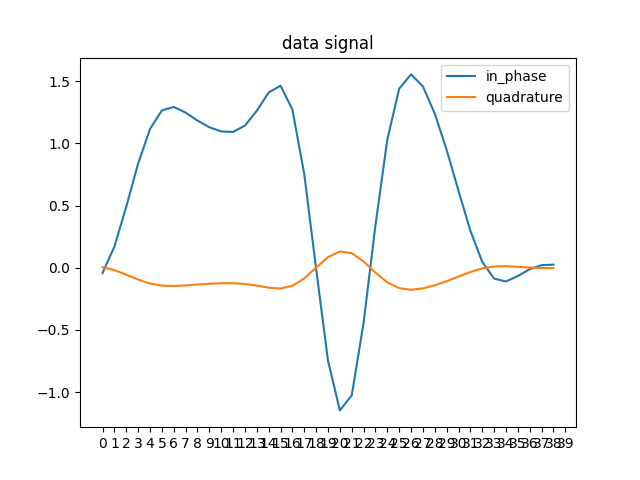

In [132]:
index_data = np.random.randint(0, inphase_data.shape[0]+1)
print(index_data)
plt.figure()
plt.title('data signal')
plt.plot(inphase_data[index_data][0], label='in_phase')
plt.plot(inphase_data[index_data][1], label='quadrature')

#rms = np.sqrt(np.mean(inphase_data[index_data]**2, axis=0))
#print(np.amin(rms), ' - ', np.amax(rms))
#plt.plot(rms, label='rms')
plt.legend()
plt.xticks(np.arange(0, 40, 1.0))
plt.show()

883


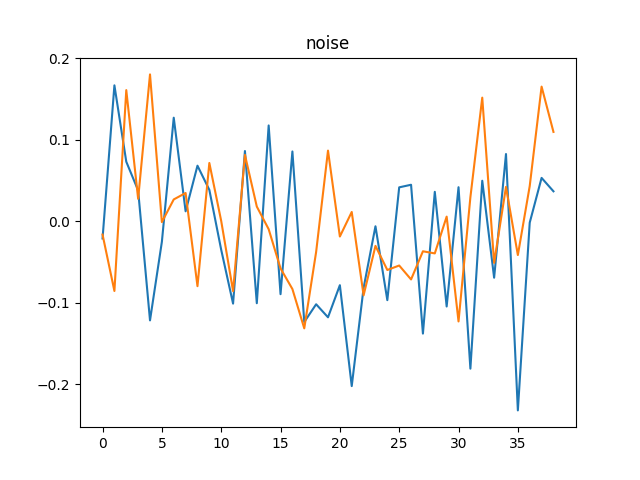

In [119]:
index_noise = np.random.randint(0, inphase_noise.shape[0]+1)
print(index_noise)
plt.figure()
plt.title('noise')
plt.plot(inphase_noise[index_noise][0], label='in_phase')
plt.plot(inphase_noise[index_noise][1], label='quadrature')
plt.show()

In [6]:
def compute_probabilities(N, Q):

    Q = float(Q)
    N = float(N)

    prob_slot_empty = (((2**Q) -1)/(2**Q))**N

    prob_slot_selected_by_1_tag = 1.0/(2**Q)
    prob_slot_not_selected_by_1_tag = (2**Q -1)/(2**Q)
    combination_tags_can_select_slot = scipy.special.binom(N, 1)

    prob_slot_single = combination_tags_can_select_slot * (prob_slot_selected_by_1_tag**1) * (prob_slot_not_selected_by_1_tag**(N-1))

    prob_slot_collided_two_transmitters = scipy.special.binom(N, 2) * (prob_slot_selected_by_1_tag**2) * (prob_slot_not_selected_by_1_tag**(N-2))

    prob_slot_collided_with_3_or_more = 0.0
    max_class_index = -1
    for k in range(3, int(N)+1):
        curr_prob = scipy.special.binom(N, float(k)) * (prob_slot_selected_by_1_tag**float(k)) * (prob_slot_not_selected_by_1_tag**(N-k))
        if(math.isnan(curr_prob) == True):
            break
        prob_slot_collided_with_3_or_more += curr_prob
        max_class_index = k

    return [prob_slot_empty, prob_slot_single, 
            prob_slot_collided_two_transmitters, 
            prob_slot_collided_with_3_or_more], max_class_index

In [8]:
4/5*1/5

0.16

In [14]:
from scipy import stats
N = 10000
Q = 100
min_val = 9999999
best_N = -1
best_Q = -1
results = []

for q in range(1, Q):
    for n in range(1,N):
        probs, max_idx = compute_probabilities(n, q)
        if(np.count_nonzero(probs) == 0):
            break
        results.append(dict({'n':n, 'q':q, 'probs':probs, 'max_idx':max_idx}))
        curr_std = np.std(probs)#np.sum(np.abs(probs - np.array([0.25, 0.25, 0.25, 0.25])))
        if(curr_std < min_val):
            #print(curr_std, ' - ', n, ' - ', q)
            min_val = curr_std
            best_N = n
            best_Q = q
print(best_N, ' - ', best_Q)

C:\Users\lvorabbi\AppData\Local\conda\conda\envs\phd_tensorflow\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


6833  -  12


In [18]:
results

[{'n': 1, 'q': 1, 'probs': [0.5, 0.5, 0.0, 0.0], 'max_idx': -1},
 {'n': 2, 'q': 1, 'probs': [0.25, 0.5, 0.25, 0.0], 'max_idx': -1},
 {'n': 3, 'q': 1, 'probs': [0.125, 0.375, 0.375, 0.125], 'max_idx': 3},
 {'n': 4, 'q': 1, 'probs': [0.0625, 0.25, 0.375, 0.3125], 'max_idx': 4},
 {'n': 5, 'q': 1, 'probs': [0.03125, 0.15625, 0.3125, 0.5], 'max_idx': 5},
 {'n': 6,
  'q': 1,
  'probs': [0.015625, 0.09375, 0.234375, 0.65625],
  'max_idx': 6},
 {'n': 7,
  'q': 1,
  'probs': [0.0078125, 0.0546875, 0.1640625, 0.7734375],
  'max_idx': 7},
 {'n': 8,
  'q': 1,
  'probs': [0.00390625, 0.03125, 0.109375, 0.85546875],
  'max_idx': 8},
 {'n': 9,
  'q': 1,
  'probs': [0.001953125, 0.017578125, 0.0703125, 0.91015625],
  'max_idx': 9},
 {'n': 10,
  'q': 1,
  'probs': [0.0009765625, 0.009765625, 0.0439453125, 0.9453125],
  'max_idx': 10},
 {'n': 11,
  'q': 1,
  'probs': [0.00048828125, 0.00537109375, 0.02685546875, 0.96728515625],
  'max_idx': 11},
 {'n': 12,
  'q': 1,
  'probs': [0.000244140625, 0.0029296

In [19]:
n_values = []
q_values = []
prob_values = []
max_idx_values = []
for item in results:
    n_values.append(item['n'])
    q_values.append(item['q'])
    prob_values.append(item['probs'])
    max_idx_values.append(item['max_idx'])
n_values = np.array(n_values)
q_values = np.array(q_values)
prob_values = np.array(prob_values)
max_idx_values = np.array(max_idx_values)

In [23]:
indexes = []
for idx, prob in enumerate(prob_values):
    two_vals = heapq.nlargest(2, prob)
    if((np.sum(two_vals) > 0.95) and (two_vals[0] > 0.47) and (two_vals[1] > 0.47)):
        indexes.append(idx)

In [ ]:
indexes2 = []
for idx, prob in enumerate(prob_values):
    two_vals = heapq.nlargest(2, prob)
    if((two_vals[0] == 1.0)):
        indexes2.append(idx)

In [42]:
gini_index = []
for idx, prob in enumerate(prob_values):
    gini_index.append(1.0 - np.sum(prob*prob))

In [65]:
entropy_index = []
for idx, prob in enumerate(prob_values):
    curr_entr = 0.0
    for val in prob:
        if (val > 0.0) and (math.isinf(val) == False):
            curr_entr += val*math.log(val)
    entropy_index.append(- curr_entr/math.log(4))

In [ ]:
from scipy.special import entr

In [69]:
prob_values[np.argmin(entropy_index)]

array([5.24155853e-17, 1.96877049e-15, 3.69704216e-14, 1.00000000e+00])

In [77]:
q_values[::-1]

array([99, 99, 99, ...,  1,  1,  1])

In [57]:
np.isinf(prob_values[1029]).any()

True

In [64]:
prob_values[0]

array([0.5, 0.5, 0. , 0. ])

In [75]:
q_values[-1]

99

In [40]:
heapq.nlargest(2, prob_values[100])

[1.0, 1.9918737856830548e-27]

In [41]:
prob_values[100]

array([3.94430453e-31, 3.98374757e-29, 1.99187379e-27, 1.00000000e+00])

In [26]:
prob_values[0]

array([0.5, 0.5, 0. , 0. ])

In [35]:
np.median([0.5, 0.5, 0. , 0. ])

0.25

In [30]:
np.sum(prob_values, axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [36]:
np.argsort(np.median(prob_values, axis=1))[::-1]

array([1377, 4172, 9923, ..., 1278, 1279, 9864], dtype=int64)

In [39]:
n_values[1377]
q_values[1377]

2

In [21]:
import heapq

In [56]:
np.std([0.25, 0.25, 0.25, 0.25])

0.0

In [36]:
from scipy import stats
probs, max_idx = compute_probabilities(85, 6)
print(probs)
stats.kstest(probs, stats.uniform(loc=0.0, scale=1.0).cdf)

[0.2622097973806179, 0.35377512345004003, 0.2358500823000267, 0.14816499686931547]


KstestResult(statistic=0.64622487654996, pvalue=0.03710614752730298)

In [39]:
np.percentile(probs, 50)

0.2490299398403223

In [81]:
probs, max_idx = compute_probabilities(6833, 12)
np.std(probs)

C:\Users\lvorabbi\AppData\Local\conda\conda\envs\phd_tensorflow\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


0.045687644368579285

In [76]:
np.count_nonzero(compute_probabilities(1371, 1))

C:\Users\lvorabbi\AppData\Local\conda\conda\envs\phd_tensorflow\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


2

In [90]:
compute_probabilities(10, 2)

([0.056313514709472656,
  0.1877117156982422,
  0.2815675735473633,
  0.4744071960449219],
 10)

In [87]:
20*0.023

0.45999999999999996

In [106]:
import pickle
base_path = 'D:/Documentazione/PhD/Corsi/Machine Learning M/Esercitazioni laboratorio/test/'

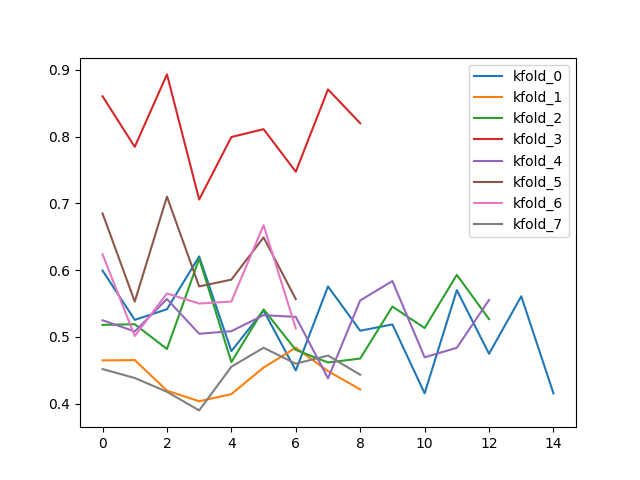

In [107]:
with open(base_path +'trainHistoryDict_dense_standardization', "rb") as file_pi:
    history = pickle.load(file_pi)
    plot_val_loss(history)

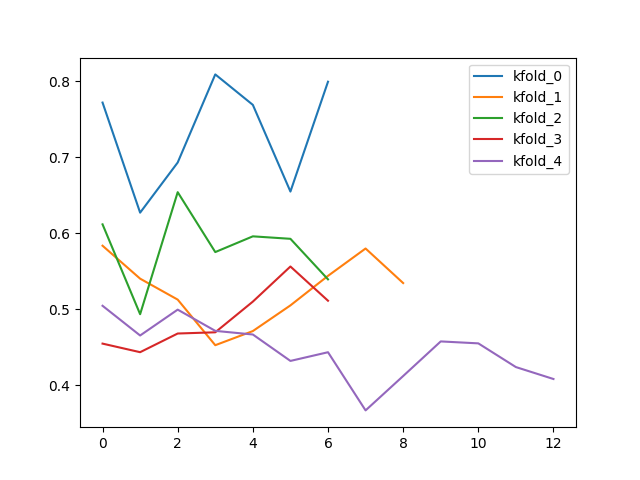

In [109]:
with open(base_path +'trainHistoryDict_dense_norm_folds_5', "rb") as file_pi:
    history = pickle.load(file_pi)
    plot_val_loss(history)

In [105]:
def plot_val_loss(history):
    plt.figure()
    for idx, curr in enumerate(history):
        plt.plot(curr['val_loss'], label='kfold_'+str(idx))
    plt.legend()
    plt.show()

In [113]:
train_ds_signal[0][0][1:]-train_ds_signal[0][0][0:-1]

array([ 0.00820606,  0.00281664, -0.01066289, -0.02826251, -0.04278793,
       -0.04887148, -0.04639948, -0.03833147, -0.02487827, -0.00121676,
        0.03647217,  0.08111378,  0.11212821,  0.10659483,  0.05740036,
       -0.01736975, -0.08383363, -0.11420219, -0.10332709, -0.06693741,
       -0.02536338,  0.01115175,  0.04330879,  0.07265616,  0.09375651,
        0.09731949,  0.07985175,  0.04845653,  0.01558221, -0.0102512 ,
       -0.02819622, -0.04086386, -0.04840602, -0.04777963, -0.03719593,
       -0.01997426, -0.00333867,  0.00650094])

In [80]:
len(pred)

15

In [78]:
gt =   [0, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 1, 0, 0, 2]
pred = [0, 1, 2, 2, 1, 0, 1, 0, 0, 0, 2, 2, 0, 0, 1]
res =  [1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]

tf.keras.metrics.Recall()(gt, pred)

InvalidArgumentError: predictions must be <= 1
Condition x <= y did not hold.
First 3 elements of x:
[0. 1. 2.]
First 1 elements of y:
[1.]

In [153]:
max_vals_phase = []
max_vals_quadrature = []
min_vals_phase = []
min_vals_quadrature = []
range_phase = []
range_quadrature = []
max_vals_amplitude = []
min_vals_amplitude = []
amplitudes = []
amplitudes2 = []
rms_phase = []

max_vals_amplitude_n = []
min_vals_amplitude_n = []
amplitudes_n = []

for sig in inphase_data:
    sig_c = np.transpose(sig)
    
    max_vals_phase.append(np.amax(sig_c[0]))
    max_vals_quadrature.append(np.amax(sig_c[1]))
    
    min_vals_phase.append(np.amin(sig_c[0]))
    min_vals_quadrature.append(np.amin(sig_c[1]))
    
    range_phase.append(np.amax(sig_c[0])-np.amin(sig_c[0]))
    range_quadrature.append(np.amax(sig_c[1])-np.amin(sig_c[1]))
    
    #amplitude = np.sqrt(np.sum(sig_c**2, axis=1)/2.0)
    amplitude = np.sqrt(np.sum(sig_c**2)/39.0)
    #amplitude = np.sqrt(np.sum(np.sum(sig_c, axis=1)**2)/39)
    rms_phase.append(np.sqrt(np.sum(sig_c[0]**2)/39.0))
    amplitudes.append(amplitude)
    amplitudes2.append(np.sqrt(np.sum(amplitude**2)/39))
    max_vals_amplitude.append(np.amax(amplitude))
    min_vals_amplitude.append(np.amin(amplitude))
    
for sig in inphase_noise:
    sig_c = np.transpose(sig)
    amplitude = np.sqrt(np.sum(sig_c**2, axis=1)/2.0)
    max_vals_amplitude_n.append(np.amax(amplitude))
    min_vals_amplitude_n.append(np.amin(amplitude))

In [139]:
amplitudes

[array([0.02274579, 0.03685667, 0.02723688, 0.02300215, 0.11098285,
        0.20461583, 0.2524881 , 0.21283956, 0.08479235, 0.08165795,
        0.20850012, 0.23340949, 0.14549917, 0.01100963, 0.16621488,
        0.2652157 , 0.29337068, 0.27401925, 0.24613133, 0.23882715,
        0.25624384, 0.2775748 , 0.27029373, 0.20995583, 0.096253  ,
        0.04482303, 0.17500411, 0.26435921, 0.30361526, 0.30089267,
        0.26929099, 0.21809477, 0.15376417, 0.0855698 , 0.02689416,
        0.01042834, 0.02312036, 0.0179126 , 0.00631579]),
 array([0.11800576, 0.03230986, 0.18752368, 0.49209075, 0.75296613,
        0.82324683, 0.6256485 , 0.20434526, 0.30102629, 0.73857155,
        1.01771977, 1.1212937 , 1.06546237, 0.86207836, 0.52236834,
        0.08659338, 0.36600964, 0.74667736, 0.99732157, 1.10067041,
        1.0566906 , 0.86162579, 0.51993332, 0.07513794, 0.3825632 ,
        0.75153478, 0.96917017, 1.03281163, 0.9775944 , 0.84022633,
        0.64490091, 0.41627231, 0.19371351, 0.02377705, 0.

In [154]:
np.where(np.array(amplitudes) < 0.3)[0].shape

(57,)

In [126]:
amplitudes2

[0.188336292991343,
 0.6623338334176868,
 0.48398506064504626,
 0.4446136144773559,
 0.41065853123589663,
 0.32574287056760887,
 0.4369945170702366,
 0.5176520547279494,
 0.3722263586127474,
 0.3263440540181027,
 0.48072316905401125,
 0.43978928009470586,
 0.21623173499097625,
 0.23882212962699972,
 0.6598888315349491,
 0.5834964791482733,
 0.6200877799112623,
 0.19646235357077263,
 0.466736972212074,
 0.18056524767868493,
 0.5765796416142686,
 0.6863802128415313,
 0.25845298867046135,
 0.21152938840583785,
 0.4921090598875178,
 0.5635576417268854,
 0.41116859888809165,
 0.18194442181078804,
 0.46632208296664274,
 0.2905194240311433,
 0.27143711829914713,
 0.6065694382017478,
 0.2067629765913225,
 0.5777258406882586,
 0.2925028306662768,
 0.6889440142716912,
 0.5209292097736521,
 0.45408782218149246,
 0.7017771891066327,
 0.29811874929163307,
 0.7313133555395988,
 0.39040880577881804,
 0.5533646877568809,
 0.6001440025267806,
 0.3445708311757512,
 0.4466128409099744,
 0.576787079201250

In [98]:
np.sort(min_vals_amplitude)[::-1]

array([4.01766553e-02, 3.76387906e-02, 3.73277654e-02, 3.53537803e-02,
       3.46060467e-02, 3.41757466e-02, 3.33739043e-02, 3.28262495e-02,
       3.14404742e-02, 3.10034552e-02, 3.03257894e-02, 3.02765586e-02,
       2.86739161e-02, 2.83301028e-02, 2.82871440e-02, 2.82508951e-02,
       2.80684896e-02, 2.77661976e-02, 2.75979038e-02, 2.74992063e-02,
       2.73500574e-02, 2.62073403e-02, 2.60621362e-02, 2.60012797e-02,
       2.57097765e-02, 2.56686266e-02, 2.56151475e-02, 2.53269800e-02,
       2.52817166e-02, 2.52190141e-02, 2.47007207e-02, 2.45291014e-02,
       2.44658857e-02, 2.42268125e-02, 2.39303787e-02, 2.37659380e-02,
       2.36432869e-02, 2.35005366e-02, 2.33515347e-02, 2.28922770e-02,
       2.27695196e-02, 2.26776509e-02, 2.18072930e-02, 2.17372342e-02,
       2.15799926e-02, 2.15741365e-02, 2.14313929e-02, 2.12198772e-02,
       2.11132721e-02, 2.09569821e-02, 2.05374753e-02, 2.03919351e-02,
       2.03495114e-02, 2.03139198e-02, 2.00587924e-02, 1.99691060e-02,
      

In [107]:
np.where(np.array(amplitudes) < 0.2)

(array([  0,   0,   0, ..., 793, 793, 793], dtype=int64),
 array([ 0,  1,  2, ..., 36, 37, 38], dtype=int64))

In [89]:
np.where(np.array(min_vals_amplitude) < 0.3)[0].shape

(1000,)

In [146]:
np.sqrt(np.sum(np.transpose(inphase_data[0])**2)/39.0)

0.26634773983543014

In [8]:
def clean_signals(inphase_data):
    
    out_signals = []
    
    for sig in inphase_data:
        sig_c = np.transpose(sig)
    
        amplitude = np.sqrt(np.sum(sig_c**2)/39.0)

        if((amplitude >= 0.3) and (amplitude <= 1.2)):
            out_signals.append(sig)
        
    return np.array(out_signals)

In [9]:
cleaned_signals = clean_signals(inphase_data)

In [16]:
np.quantile(max_vals_phase, 0.90)

0.0929665860846401

In [24]:
np.quantile(max_vals_quadrature, 0.90)

0.15768052925331227

In [117]:
np.sqrt(np.sum(amplitudes[1]**2)/39)

0.6623338334176868

In [128]:
np.where(np.array(amplitudes2) < 0.3)[0]

array([  0,  12,  13,  17,  19,  22,  23,  27,  29,  30,  32,  34,  39,
        59,  65,  70,  73,  76,  79,  84,  94,  95,  97, 100, 111, 113,
       128, 131, 132, 133, 134, 139, 144, 149, 152, 156, 158, 161, 172,
       174, 183, 189, 199, 201, 207, 208, 213, 221, 224, 226, 232, 235,
       245, 251, 254, 257, 261, 262, 264, 277, 284, 286, 310, 314, 315,
       323, 335, 338, 346, 348, 349, 354, 360, 366, 367, 368, 373, 374,
       382, 385, 391, 399, 403, 404, 420, 421, 427, 443, 444, 447, 449,
       450, 452, 463, 464, 468, 472, 474, 476, 479, 480, 481, 482, 485,
       487, 490, 501, 505, 510, 512, 517, 518, 522, 527, 532, 534, 536,
       538, 541, 545, 559, 561, 568, 570, 576, 584, 590, 594, 599, 603,
       604, 608, 609, 613, 629, 642, 647, 651, 656, 663, 668, 672, 675,
       678, 682, 700, 702, 707, 713, 715, 716, 718, 721, 733, 734, 740,
       752, 758, 761, 763, 764, 765, 771, 778, 782, 791, 795, 797, 798,
       802, 805, 810, 814, 825, 826, 835, 838, 843, 849, 854, 86

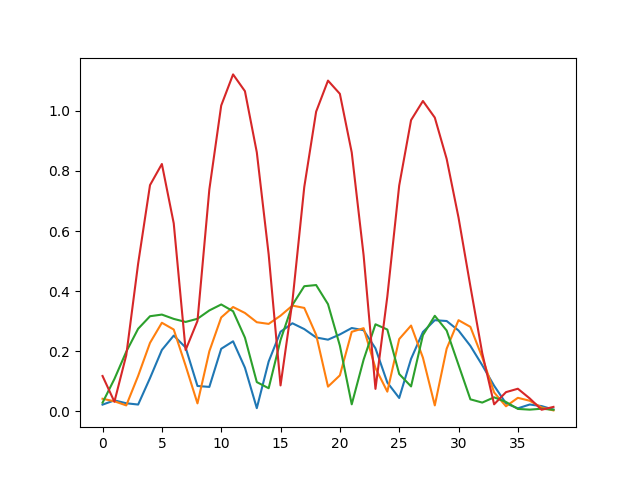

In [131]:
plt.figure()
plt.plot(amplitudes[0])
plt.plot(amplitudes[12])
plt.plot(amplitudes[13])
plt.plot(amplitudes[1])
plt.show()

In [60]:
np.where(np.array(min_vals_amplitude) < 0.1)[0].shape

(1000,)

In [59]:
np.amin(min_vals_amplitude)

5.89621650231075e-06

In [46]:
idxes_to_ex

array([  7,   8,  12,  22,  27,  60,  65,  71,  72,  75,  77,  88,  90,
       104, 128, 146, 156, 158, 167, 178, 182, 186, 197, 199, 204, 205,
       208, 211, 217, 222, 227, 232, 234, 248, 254, 258, 275, 288, 329,
       345, 346, 365, 400, 402, 403, 405, 406, 410, 439, 449, 451, 463,
       465, 477, 491, 492, 530, 537, 555, 578, 588, 599, 621, 631, 633,
       647, 663, 676, 685, 696, 701, 703, 704, 740, 746, 749, 780, 795,
       802, 805, 828, 838, 843, 849, 854, 865, 875, 884, 895, 897, 913,
       926, 948, 963, 967, 974, 980, 981, 985, 995, 996], dtype=int64)

In [47]:
amplitudes[7]

array([0.05977465, 3.23218337])

In [48]:
np.sqrt(np.sum(np.transpose(inphase_data[0])**2, axis=1)/2.0)

array([0.02274579, 0.03685667, 0.02723688, 0.02300215, 0.11098285,
       0.20461583, 0.2524881 , 0.21283956, 0.08479235, 0.08165795,
       0.20850012, 0.23340949, 0.14549917, 0.01100963, 0.16621488,
       0.2652157 , 0.29337068, 0.27401925, 0.24613133, 0.23882715,
       0.25624384, 0.2775748 , 0.27029373, 0.20995583, 0.096253  ,
       0.04482303, 0.17500411, 0.26435921, 0.30361526, 0.30089267,
       0.26929099, 0.21809477, 0.15376417, 0.0855698 , 0.02689416,
       0.01042834, 0.02312036, 0.0179126 , 0.00631579])

In [32]:
max_vals_amplitude

[0.8697106111086403,
 3.4455036725872654,
 2.2953935493097877,
 2.7651679139729026,
 2.4322259397370973,
 1.9682431354035832,
 2.511314259605127,
 3.2321833691710817,
 2.324387814817162,
 2.0242854074528767,
 2.445678388452084,
 2.7327287878138997,
 1.350365033225723,
 1.461939913865301,
 4.03472692835879,
 2.7852312943568753,
 3.272119449850941,
 1.0743364112171436,
 2.782288666762789,
 0.947808195847271,
 3.270809320696111,
 3.2423587630436925,
 1.6036333161757121,
 1.2369047672466238,
 3.0020029155400785,
 3.4822555670049606,
 2.4620756754540656,
 1.1362385766273069,
 2.1107038726486165,
 1.468404560316212,
 1.6093070116729138,
 3.7524382339741336,
 1.061858242947527,
 3.380366938178617,
 1.395038365336922,
 4.020978186772384,
 2.679833751810397,
 2.821523704345696,
 4.271307934242012,
 1.8507460700614653,
 4.209755413359301,
 1.9773675116413354,
 3.343244233876821,
 3.6884606779186107,
 2.019897495129125,
 2.5239015003872796,
 3.0434080209452037,
 2.2435380464447987,
 2.28012590350

In [10]:
len(cleaned_signals)

943

In [136]:
amplitudes = []
for sig in inphase_noise:
    
    amplitude = np.sqrt(np.sum(sig**2)/39.0)
    amplitudes.append(amplitude)

In [137]:
amplitudes.sort()

In [138]:
amplitudes

[0.10270054169706563,
 0.11084363575162168,
 0.1112552350746084,
 0.11218342725937332,
 0.11384723697504308,
 0.11390446892879041,
 0.11408746388449663,
 0.11467489284976316,
 0.1152574936827057,
 0.11540492434751991,
 0.1155291933749449,
 0.11573003195995903,
 0.11634190482139033,
 0.11676891904540057,
 0.11758697556371808,
 0.11779636504435104,
 0.11780112691811727,
 0.11791040441717093,
 0.11808099028385,
 0.11814352361754403,
 0.11842656770945564,
 0.11847046612534837,
 0.11915677011534188,
 0.1191639704607997,
 0.11974949733377471,
 0.11984504267907699,
 0.12002925389138511,
 0.12031771275331556,
 0.1204700012056007,
 0.1204940975434362,
 0.12051845836896966,
 0.12067200769169062,
 0.12068466401039467,
 0.12072571687728224,
 0.12077663377713947,
 0.12077943429481869,
 0.12077986915859736,
 0.12082928441552315,
 0.12115606339098561,
 0.12137319478636963,
 0.12145338554628154,
 0.12145697877684336,
 0.12162879864639664,
 0.1216914339863174,
 0.12191708933994125,
 0.12198490049519574

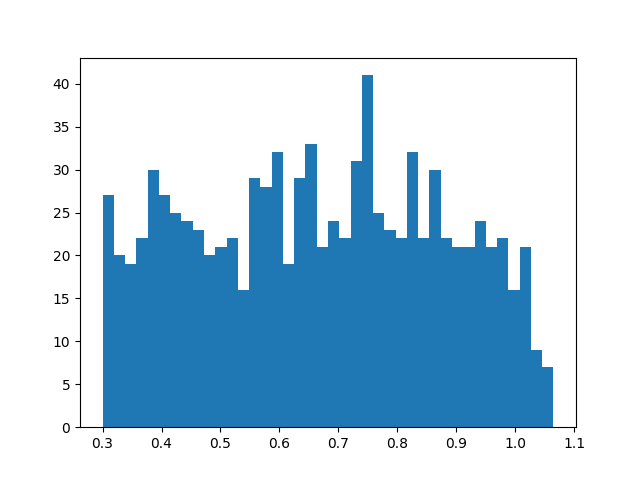

In [59]:
plt.figure()
plt.hist(amplitudes, bins=40)
plt.show()

In [49]:
counts, bins = np.histogram(amplitudes, bins=40)
print(np.std(counts))

6.135501202020908


In [102]:
counts

array([27, 20, 19, 22, 30, 27, 25, 24, 23, 20, 21, 22, 16, 29, 28, 32, 19,
       29, 33, 21, 24, 22, 31, 41, 25, 23, 22, 32, 22, 30, 22, 21, 21, 24,
       21, 22, 16, 21,  9,  7], dtype=int64)

In [60]:
bin_index = np.digitize(0.65, bins)

# Get the range (edges) of the bin
bin_range = (bins[bin_index - 1], bins[bin_index])

In [94]:
np.digitize(1.06444842783017, bins)

41

In [133]:
def sample_signals_per_bin(signals, test_set_percent=0.3):
    
    amplitudes = []
    for sig in signals:
        amplitude = np.sqrt(np.sum(sig**2)/39.0)
        amplitudes.append(amplitude)
        
    amplitudes = np.array(amplitudes)
    counts_in_bin, bin_edges = np.histogram(amplitudes, bins=40)
    
    all_signals = [[] for _ in range(len(counts_in_bin))]
    for sig in signals:
        amplitude = np.sqrt(np.sum(sig**2)/39.0)
        
        bin_index = np.digitize(amplitude, bin_edges)-1
        if(bin_index == len(counts_in_bin)):
            bin_index -= 1
        bin_range = (bin_edges[bin_index - 1], bin_edges[bin_index])
        
        all_signals[bin_index].append(sig)
        
    train_signals = []
    test_signals = []
    for bin_id in range(len(counts_in_bin)):        
        train_signals_curr, test_signals_curr = train_test_split(splitted_signals[bin_id], test_size=test_set_percent, random_state=42)
        train_signals.append(np.array(train_signals_curr))
        test_signals.append(np.array(test_signals_curr))
      
    train_signals = np.array(train_signals)
    test_signals = np.array(test_signals)
    train_signals = np.concatenate([x for x in train_signals], axis=0)
    test_signals = np.concatenate([x for x in test_signals], axis=0)
        
    return all_signals, train_signals, test_signals

In [134]:
splitted_signals, train_signals, test_signals = sample_signals_per_bin(cleaned_signals)

C:\Users\lvorabbi\AppData\Local\conda\conda\envs\phd_tensorflow\lib\site-packages\ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\lvorabbi\AppData\Local\conda\conda\envs\phd_tensorflow\lib\site-packages\ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [105]:
np.random.shuffle(np.array(splitted_signals[0]))

In [108]:
train_ds_noise, test_ds_noise = train_test_split(splitted_signals[0], test_size=0.2, random_state=42)

In [107]:
from sklearn.model_selection import train_test_split

In [109]:
len(train_ds_noise)

21

In [135]:
test_signals.shape

(301, 2, 39)

In [120]:
train_signals[0].shape

(18, 2, 39)

In [121]:
np.concatenate([train_signals[0], train_signals[1]], axis=0).shape

(32, 2, 39)

In [122]:
np.concatenate([x for x in train_signals], axis=0).shape

(642, 2, 39)

In [123]:
np.concatenate([x for x in test_signals], axis=0).shape

(301, 2, 39)

In [3]:
import pickle

In [4]:
with open('C:/Proj/phd/core50_evaluation/signals_collisions_train.pickle', 'rb') as handle:
    features = pickle.load(handle)

In [5]:
with open('C:/Proj/phd/core50_evaluation/signals_collisions_train_labels.pickle', 'rb') as handle:
    labels = pickle.load(handle)

In [6]:
indexes_0 = np.where(labels==0)[0]
indexes_1 = np.where(labels==1)[0]
indexes_2 = np.where(labels==2)[0]
indexes_3 = np.where(labels==3)[0]

signals_0 = features[indexes_0]
signals_1 = features[indexes_1]
signals_2 = features[indexes_2]
signals_3 = features[indexes_3]

In [13]:
def save_box_plot(signals_0, signals_1, signals_2, signals_3, index, title):
    
    finals = np.concatenate([np.expand_dims(signals_0[:,index], axis=1), np.expand_dims(signals_1[:,index], axis=1), np.expand_dims(signals_2[:,index], axis=1), np.expand_dims(signals_3[:,index], axis=1)], axis=1)
    
    fig, ax = plt.subplots()
    boxplot  = ax.boxplot(finals, positions=[2, 4, 6, 8], widths=1.5, patch_artist=True,
                    showmeans=True, showfliers=False,
                    medianprops={"color": "white", "linewidth": 0.5},
                    boxprops={"facecolor": "C0", "edgecolor": "white",
                              "linewidth": 0.5},
                    whiskerprops={"color": "C0", "linewidth": 1.5},
                    capprops={"color": "C0", "linewidth": 1.5})
    x_tick_labels = ['Empty', '1-Signal', '2-collided', '3-collided']

    # Set the x-tick labels
    ax.set_xticklabels(x_tick_labels)
    plt.title(title)
    plt.savefig('D:/Documentazione/PhD/Corsi/Machine Learning M/Esercitazioni laboratorio/test/'+title+'.png')

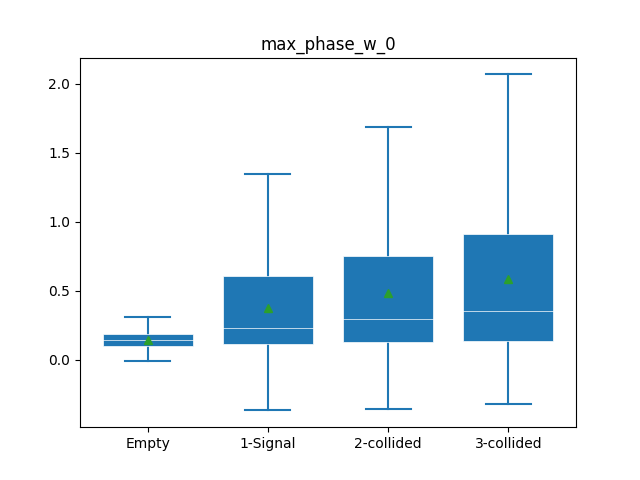

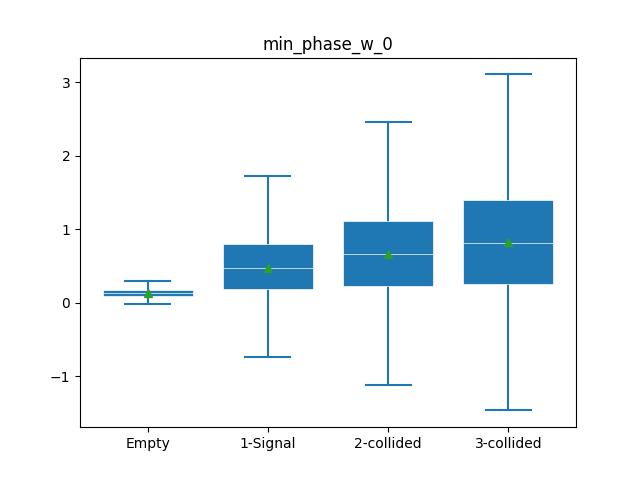

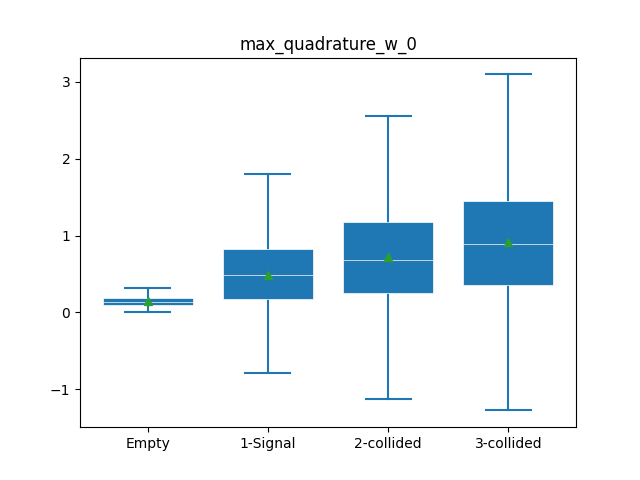

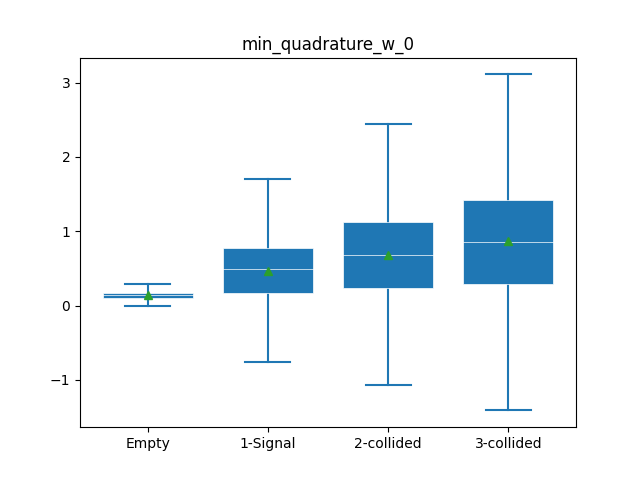

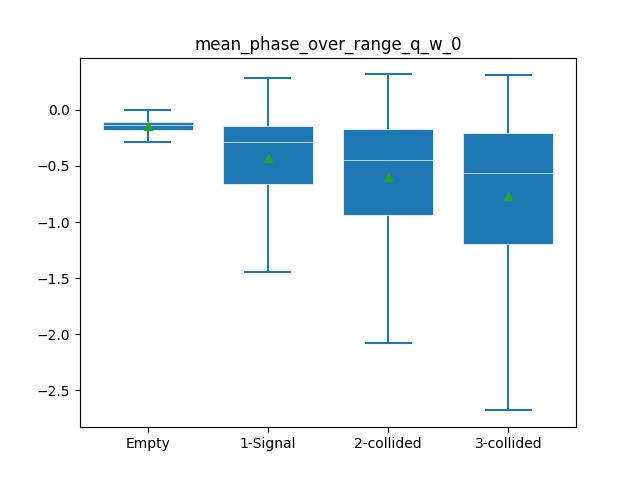

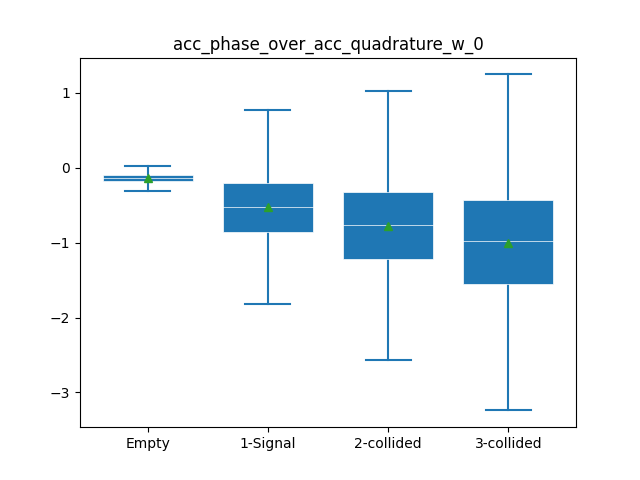

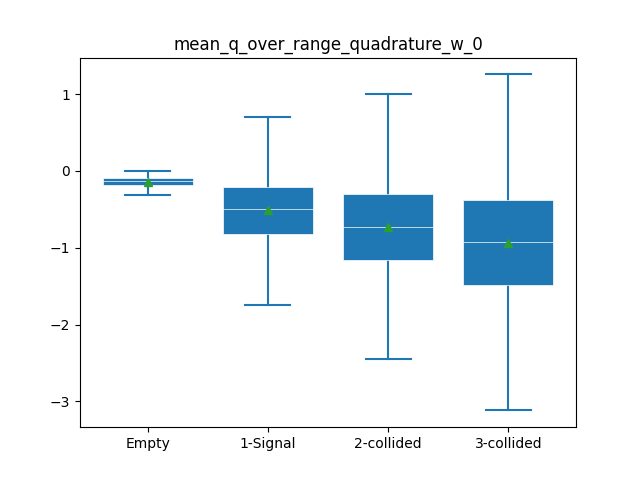

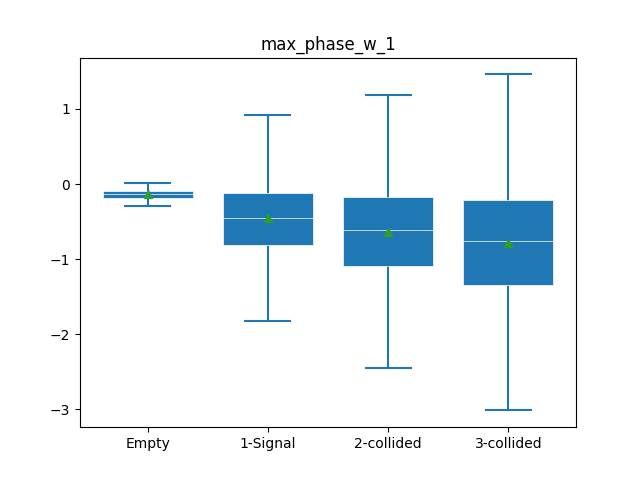

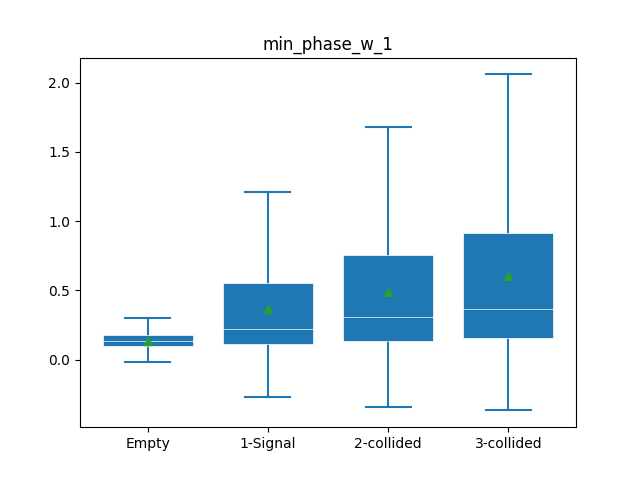

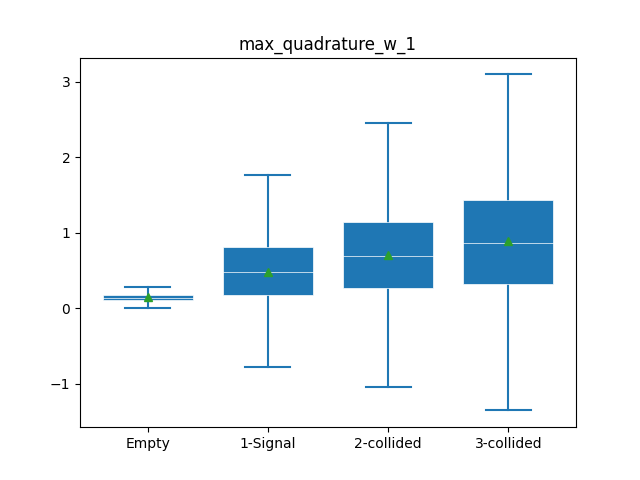

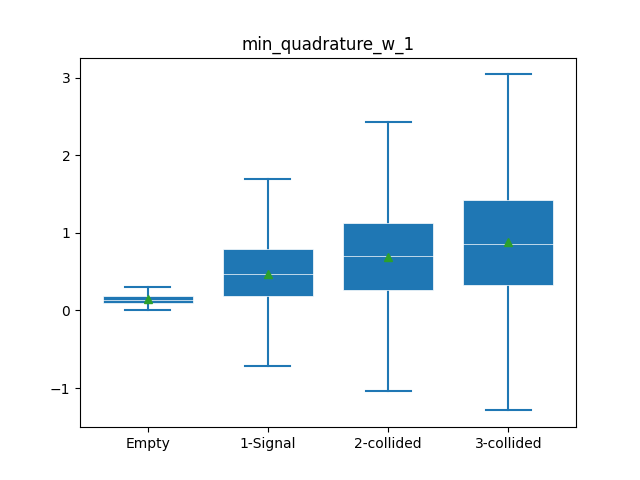

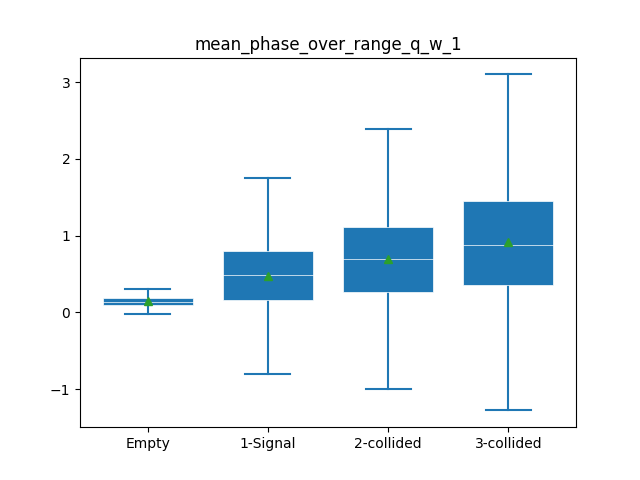

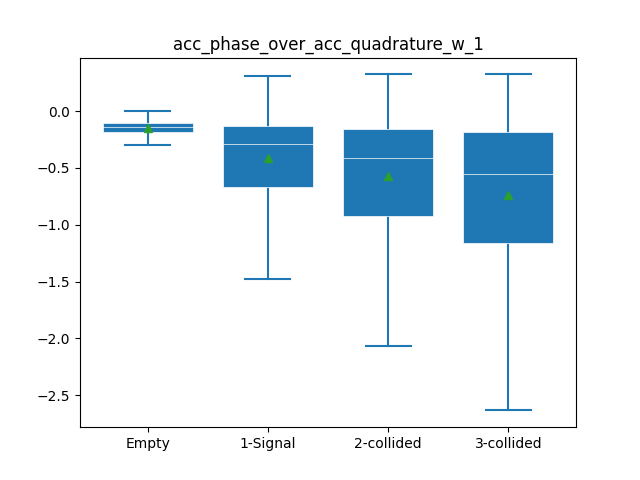

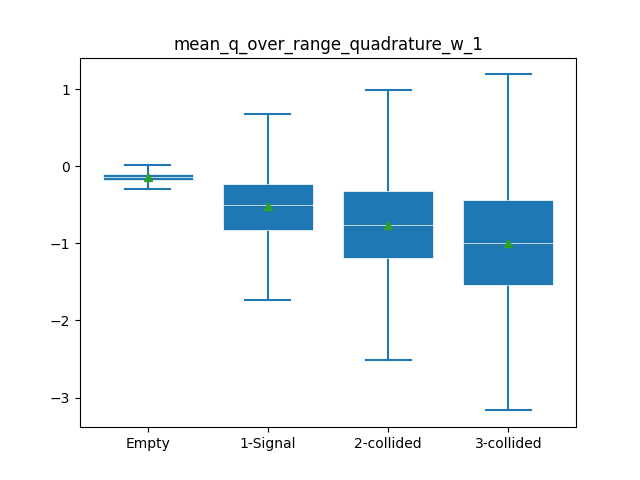

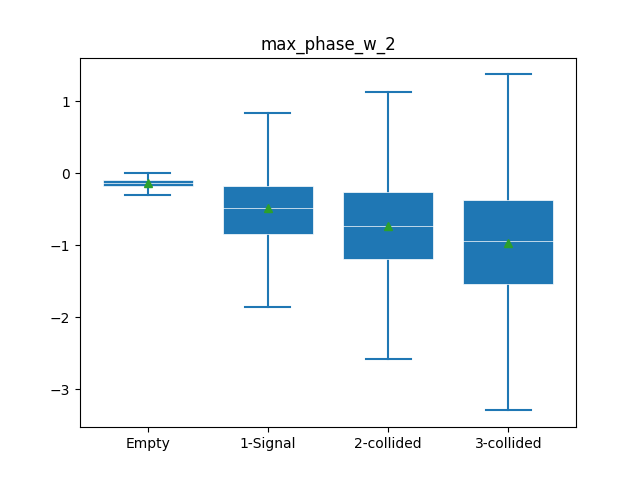

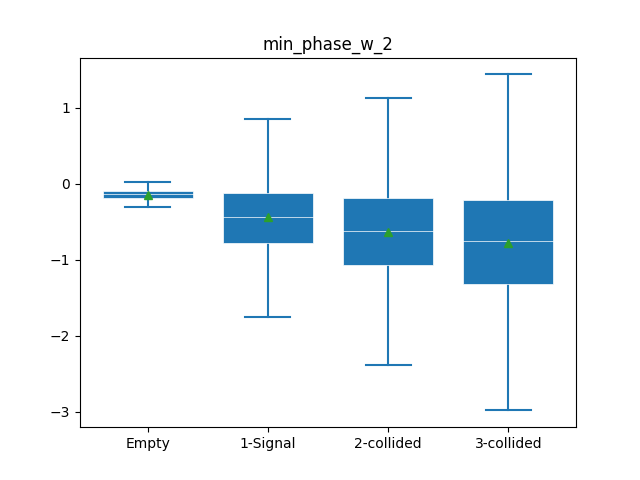

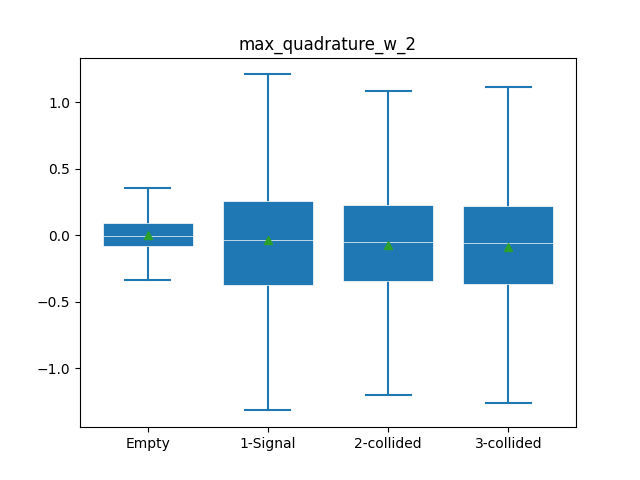

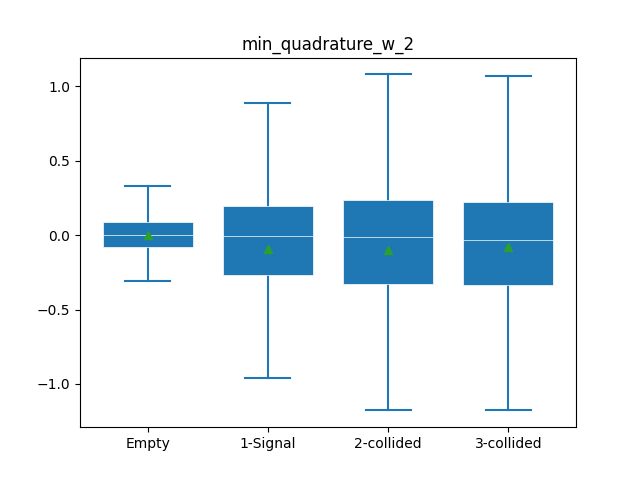

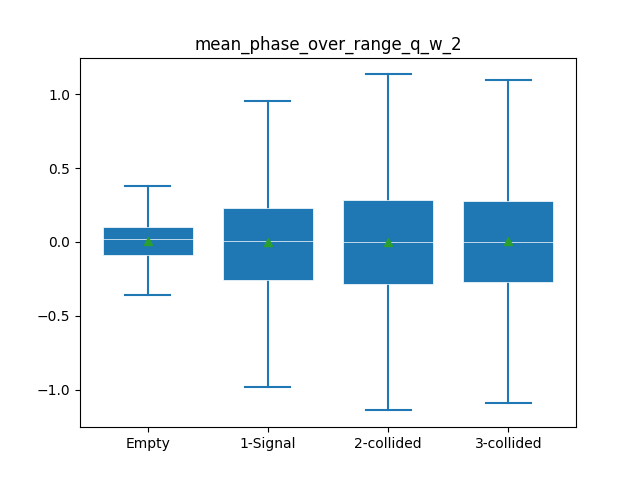

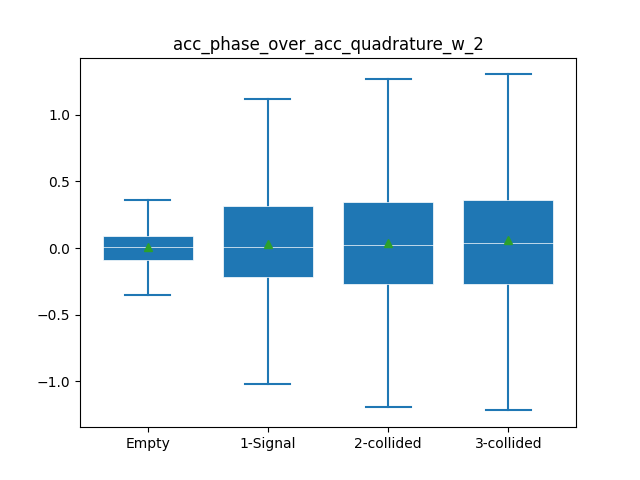

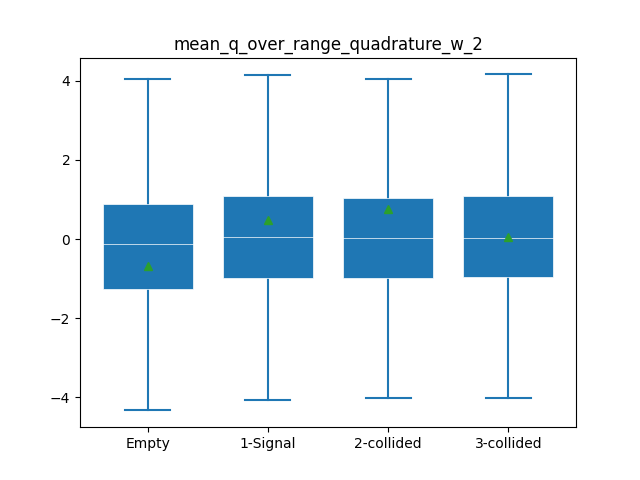

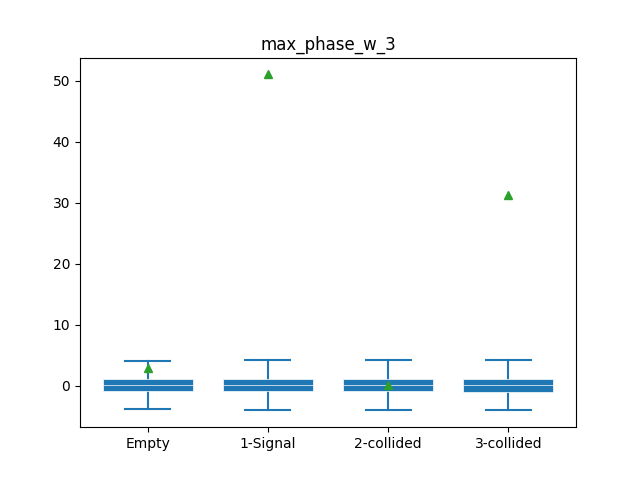

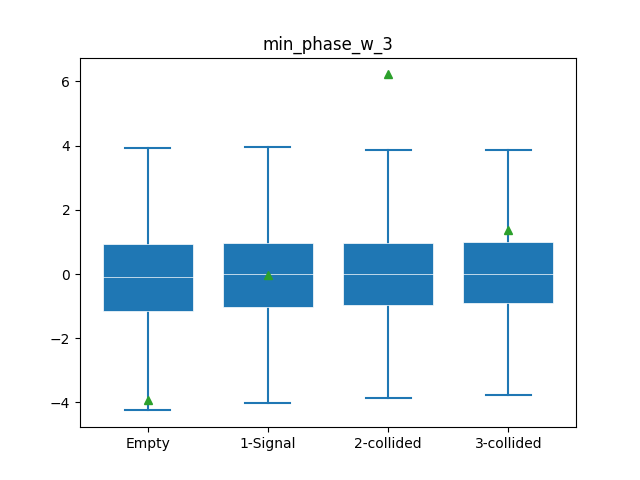

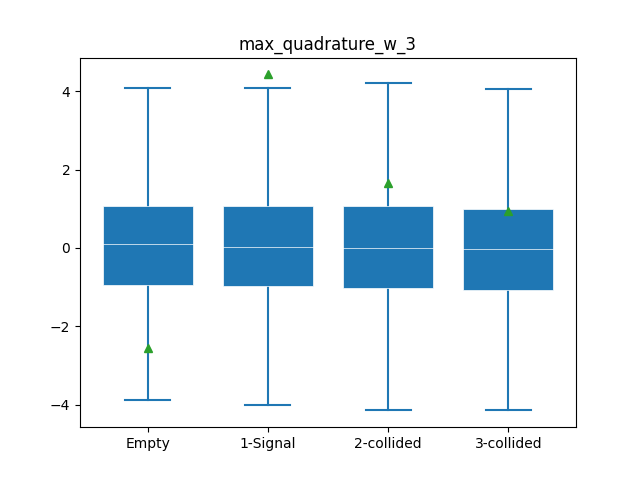

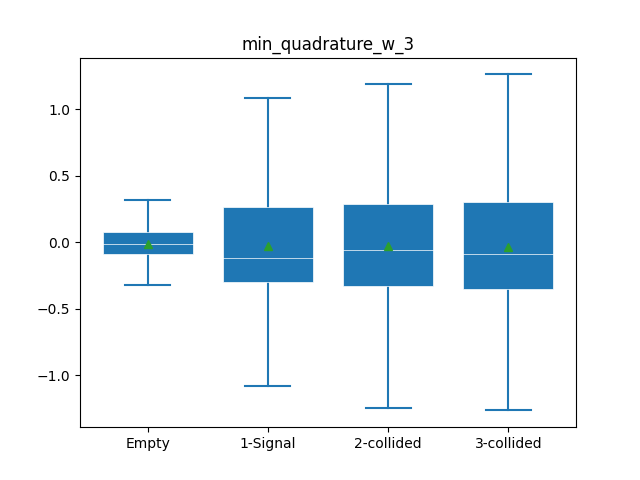

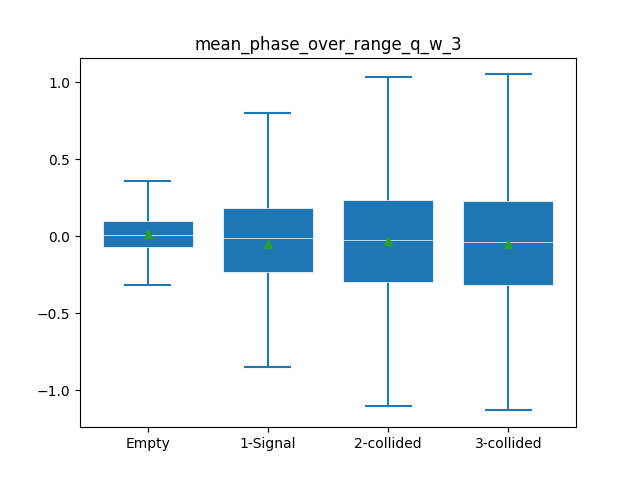

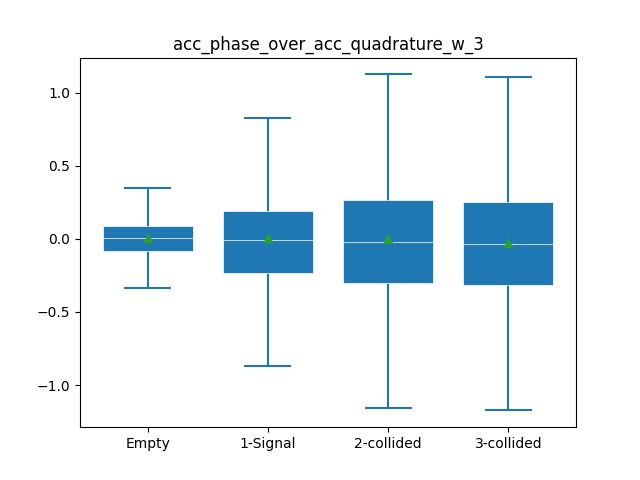

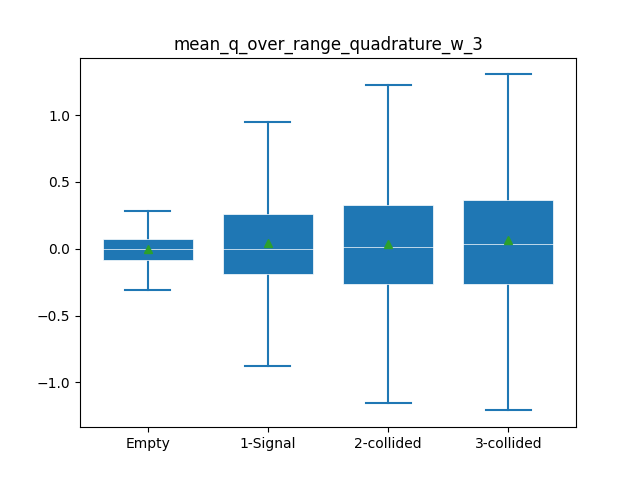

In [14]:

titles = ['max_phase_w_0', 'min_phase_w_0', 'max_quadrature_w_0', 'min_quadrature_w_0', 'mean_phase_over_range_q_w_0', 'acc_phase_over_acc_quadrature_w_0', 'mean_q_over_range_quadrature_w_0',
          'max_phase_w_1', 'min_phase_w_1', 'max_quadrature_w_1', 'min_quadrature_w_1', 'mean_phase_over_range_q_w_1', 'acc_phase_over_acc_quadrature_w_1', 'mean_q_over_range_quadrature_w_1',
          'max_phase_w_2', 'min_phase_w_2', 'max_quadrature_w_2', 'min_quadrature_w_2', 'mean_phase_over_range_q_w_2', 'acc_phase_over_acc_quadrature_w_2', 'mean_q_over_range_quadrature_w_2',
          'max_phase_w_3', 'min_phase_w_3', 'max_quadrature_w_3', 'min_quadrature_w_3', 'mean_phase_over_range_q_w_3', 'acc_phase_over_acc_quadrature_w_3', 'mean_q_over_range_quadrature_w_3']
for i in range(28):
    
    save_box_plot(signals_0, signals_1, signals_2, signals_3, i, titles[i])

In [79]:
from sklearn.manifold import TSNE

In [16]:
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
data_tsne = tsne.fit_transform(features)

In [17]:
data_tsne.shape

(79816, 2)

C:\Users\lvorabbi\AppData\Local\conda\conda\envs\phd_tensorflow\lib\site-packages\matplotlib\collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


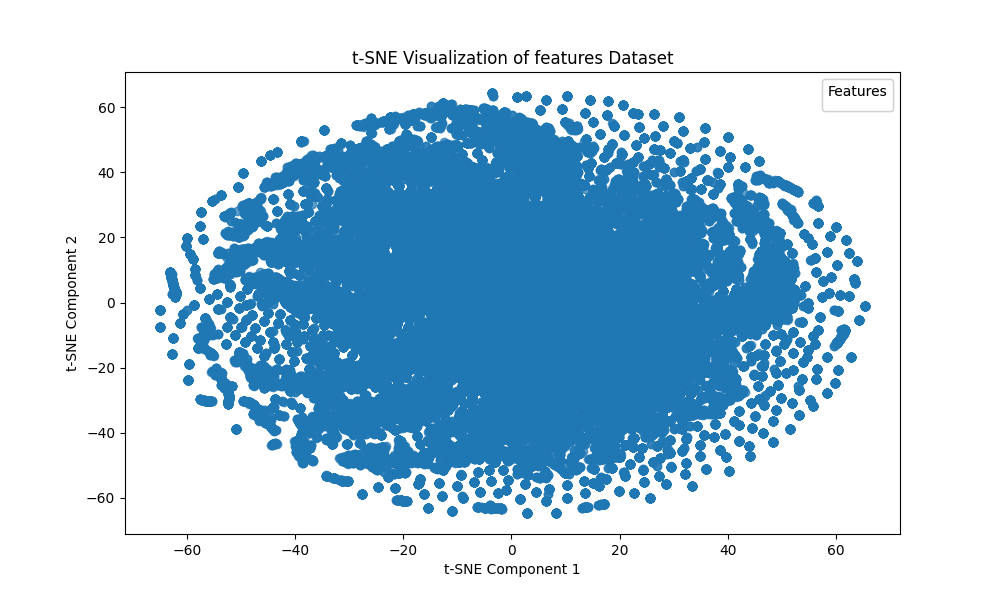

In [18]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], cmap='viridis', alpha=0.7)

# Add a color bar with the labels
legend1 = plt.legend(*scatter.legend_elements(), title="Features")
plt.gca().add_artist(legend1)

# Add labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of features Dataset')
plt.show()

In [71]:
from sklearn.cluster import KMeans

In [39]:
test_signals = np.concatenate([signals_0[:100], signals_1[:100], signals_2[:100], signals_3[:100]], axis=0)

In [40]:
test_signals.shape

(400, 28)

In [72]:
from sklearn.decomposition import PCA

In [73]:
pca = PCA(n_components=2)

# Fit PCA to the data and transform the data
data_pca = pca.fit_transform(features_scaled)

# Print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.14600847 0.0885413 ]


In [80]:
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
data_pca = tsne.fit_transform(features_scaled)

In [81]:
data_pca.shape

(79816, 2)

In [91]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [82]:
kmeans = KMeans(n_clusters=4)

# Fit the KMeans model to the data
kmeans.fit(data_pca)

# Get the cluster centers and labels
centers = kmeans.cluster_centers_
labels = kmeans.labels_

In [83]:
centers

array([[ 33.805645 ,  -2.9080408],
       [-34.013954 ,   2.4100327],
       [  2.8826451,  33.25978  ],
       [ -3.0538037, -34.14576  ]], dtype=float32)

In [88]:
labels

array([0, 3, 0, ..., 2, 0, 2])

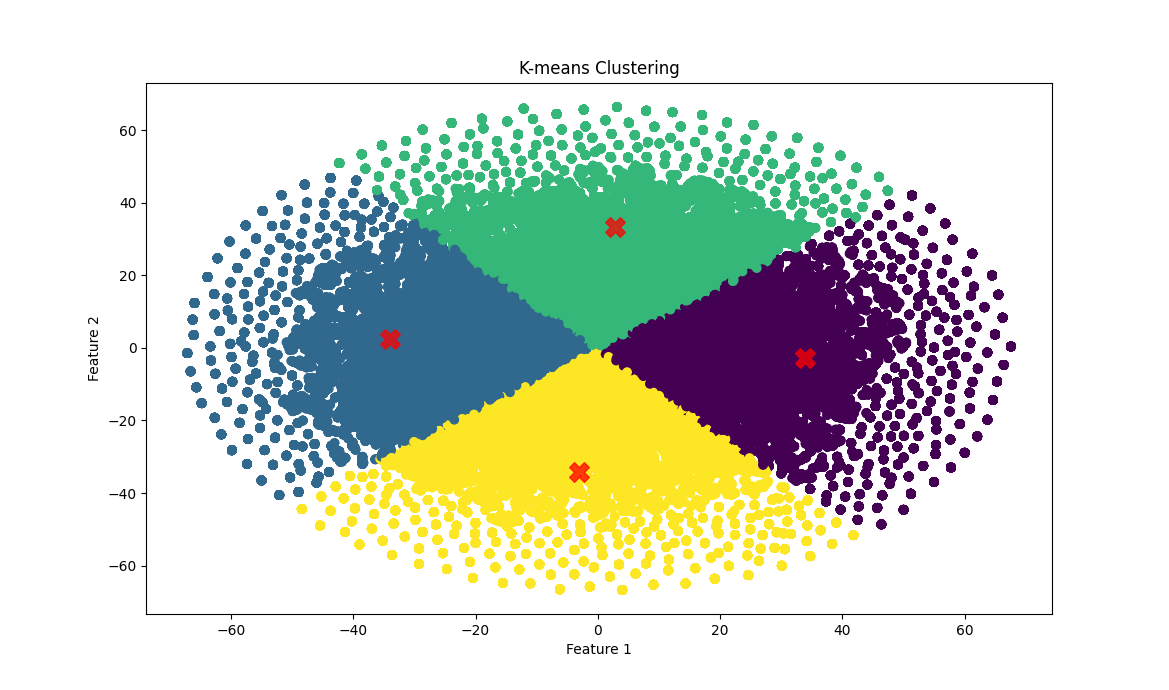

In [90]:
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels)

# Plot the cluster centers
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')

# Add labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering')

# Display the plot
plt.show()

In [89]:
index = np.random.randint(0, data_pca.shape[0])
print(kmeans.predict(np.expand_dims(data_pca[index], axis=0)))
print(labels[index])

[0]
0


In [127]:
correct = 0
failed = 0
for i in range(data_pca.shape[0]):
    pred = kmeans.predict(np.expand_dims(data_pca[i], axis=0))[0]
    if(pred == labels[i]):
        correct += 1
    else:
        failed += 0
print(correct)
print(failed)

79816
0


In [6]:
with open('C:/Proj/phd/core50_evaluation/signals_collisions_val.pickle', 'rb') as handle:
    features_val = pickle.load(handle)

In [7]:
with open('C:/Proj/phd/core50_evaluation/signals_collisions_val_labels.pickle', 'rb') as handle:
    labels_val = pickle.load(handle)

In [95]:
kmeans.predict(np.expand_dims(data_pca[i], axis=0))[0]

AttributeError: 'TSNE' object has no attribute 'predict'

In [126]:
val_pca = pca.transform(features_val)
correct = 0
failed = 0
for i in range(val_pca.shape[0]):
    pred = kmeans.predict(np.expand_dims(val_pca[i], axis=0))[0]
    if(pred == labels_val[i]):
        correct += 1
    else:
        failed += 1
print(correct)
print(failed)

18
48


In [125]:
val_pca.shape[0]

66

In [109]:
pca.get_covariance().shape

(28, 28)

In [123]:
(pca.components_@features_val[0])

array([-1.24474998, -1.0077493 ])

In [118]:
np.transpose(np.expand_features_val[0])

array([ 0.13742636, -0.42944642,  0.98000898,  0.07962908, -0.76722018,
       -0.846241  , -0.09952869, -0.85435848,  0.51267058,  0.77255386,
        0.05252269,  0.81508382, -0.19512586,  0.37592353, -0.88299488,
       -0.24014415, -0.4160863 , -1.75670069,  0.56566956, -0.49841759,
       -1.927627  , -1.24634247, -1.00947256, -1.23457335,  0.21585415,
        1.40948474, -0.5603615 ,  0.40371647])

In [119]:
pca.components_.shape

(2, 28)

In [58]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import  RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB

In [8]:
features_scaled = (features-np.mean(features, axis=0))/np.std(features, axis=0)

In [12]:
features_val_scaled = (features_val-np.mean(features, axis=0))/np.std(features, axis=0)

In [92]:
classifier = LinearDiscriminantAnalysis()
classifier.fit(features_scaled, labels)

LinearDiscriminantAnalysis()

In [31]:
classifier = LogisticRegression(multi_class='multinomial',solver ='newton-cg')
classifier.fit(features_scaled, labels)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [42]:
classifier = AdaBoostClassifier()
classifier.fit(features_scaled, labels)

AdaBoostClassifier()

In [68]:
clf1 = RandomForestClassifier(n_estimators=30, random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = RandomForestClassifier(n_estimators=70, random_state=1)
classifier = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
classifier = classifier.fit(features_scaled, labels)
onevsrest_classifier = OneVsRestClassifier(classifier)

In [93]:
val_preds = classifier.predict(features_val_scaled)

In [26]:
classifier = LogisticRegression()

# Wrap the classifier with OneVsRestClassifier
onevsrest_classifier = OneVsRestClassifier(classifier)

In [25]:
ovevsoneclassifier = OneVsOneClassifier(classifier)

In [27]:
onevsrest_classifier.fit(features_scaled, labels)

OneVsRestClassifier(estimator=LogisticRegression())

In [26]:
ovevsoneclassifier.fit(features_scaled, labels)

OneVsOneClassifier(estimator=LogisticRegression())

In [28]:
val_preds = onevsrest_classifier.predict(features_val_scaled)

In [27]:
val_preds = ovevsoneclassifier.predict(features_val_scaled)

In [94]:
np.where(val_preds==labels_val)[0].shape

(22,)

In [29]:
labels_val.shape

(66,)

In [25]:
np.where(tf.round(val_preds)==labels_val)[0].shape

(41,)

In [40]:
53/66

0.803030303030303